## Customer sentiment analysis

This project will focus on using Natural Language Processing (NLP) techniques to find broad trends in the written thoughts of the customers. The goal in this project is to predict whether customers recommend the product they purchased using the information in their review text.

One of the challenges in this project is to extract useful information from the "Review Text" variable using text mining techniques. The other challenge is that we need to convert text files into numeric feature vectors to run machine learning algorithms.

## 1.LIBRARIES NEEDED IN THE PROJECT

## 1.1 User Defined Functions 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


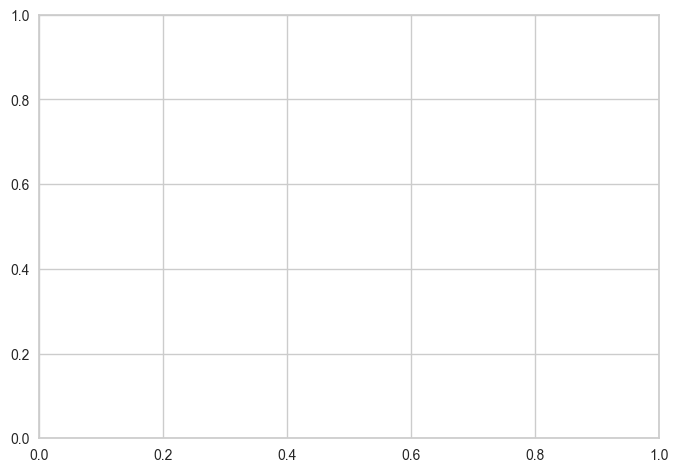

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud 
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score

from yellowbrick.classifier import PrecisionRecallCurve

import nltk
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.express as px
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
%matplotlib inline
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (12, 8) 
pd.set_option('max_colwidth', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

import pandas_profiling
from pandas_profiling.report.presentation.flavours.html.templates import create_html_assets

In [10]:
###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop realted columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
    
###############################################################################

# To view summary information about the column

def first_look(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))
    
###############################################################################

## 2. Data 

### 2.1 Context

In this context, the basic goal of this project is to predict whether customers, especially assumed as women, recommend the product they purchased using the information in their Review Text. Especially, it should be noted that the expectation in this project is to use only the "Review Text" variable and neglect the other ones. Of course, if you want, you can work on other variables individually.

The data is a collection of 22641 Rows and 10 column variables. Each row includes a written comment as well as additional customer information. Also each row corresponds to a customer review, and includes the variables. Because this is real commercial data, it has been anonymized, and references to the company in the review text and body have been replaced with "retailer".

### 2.2 About the Features 

1) Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.

2) Age: Positive Integer variable of the reviewers age.

3) Title: String variable for the title of the review.

4) Review Text: String variable for the review body.

5) Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.

6) Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

7) Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.

8) Division Name: Categorical name of the product high level division.

9) Department Name: Categorical name of the product department name.

10) Class Name: Categorical name of the product class name.

## 3) ANALYSIS 

### 3.1 Reading the Data

In [11]:
df0 = pd.read_csv("BA - Assignment Part 2 data set.csv")
df = df0.copy()
df_dl = df0.copy()
df.head()

Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                                                                                                                                                                               Review Text  \
0                                                                                                                                                    Absolutely wonderful - silky and sexy and comfortable   
1  Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length...   
2  I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i co...   
3                                                                             I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!   
4         This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!   

   Rating  Recommended IND  Positive Feedback Count   Division Name  \
0       4                1                        0       Initmates   
1       5                1                        4         General   
2       3                0                        0         General   
3       5                1                        0  General Petite   
4       5                1                        6         General   

  Department Name Class Name  
0        Intimate  Intimates  
1         Dresses    Dresses  
2         Dresses    Dresses  
3         Bottoms      Pants  
4            Tops    Blouses

## 4) EXPLORATORY DATA ANALYSIS (EDA) & VISUALIZATION

### 4.1 - A General Looking at the Data  

Pandas profiling is an open source Python module with which we can quickly do an exploratory data analysis with just a few lines of code. Similarly, for EDA, profile_report() is One-Line Magical Code creating reports in the interactive HTML format which is quite easy to understand and analyze the data. In short, at the first hand, what pandas profiling does is to save us all the work of visualizing and understanding the distribution of each variable.

In [12]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
first_looking(df)

Shape:(23486, 11)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB
None
------------------------------------------

In the proces above, we have prefered to rename the column names.

In [14]:
df.head(1)

unnamed:_0  clothing_id  age title  \
0           0          767   33   NaN   

                                             review_text  rating  \
0  Absolutely wonderful - silky and sexy and comfortable       4   

   recommended_ind  positive_feedback_count division_name department_name  \
0                1                        0     Initmates        Intimate   

  class_name  
0  Intimates

In [15]:
df.sample(3)

unnamed:_0  clothing_id  age                        title  \
10609       10609          862   41  Beautiful embroidery detail   
3967         3967          860   33                          NaN   
17672       17672          862   65              Love this tunic   

                                                                                                                                                                                                   review_text  \
10609  I bought this top in the gray color and my usual size large.   the fit is perfect.  i don't have the tight neck issue that another reviewer had.  there is an odd knitted neck that you can't see on...   
3967                                                                                                                                                                                                       NaN   
17672                                                                                    This tunic is wonderful, wash & wear - comfortable and classic - love the trim. \r\n\r\nmany compliments on this top.   

       rating  recommended_ind  positive_feedback_count   division_name  \
10609       4                1                        1  General Petite   
3967        5                1                        0  General Petite   
17672       5                1                        2  General Petite   

      department_name class_name  
10609            Tops      Knits  
3967             Tops      Knits  
17672            Tops      Knits

In [16]:
df.shape

(23486, 11)

In [17]:
df.drop("unnamed:_0", axis=1, inplace=True)
df.head(1)

clothing_id  age title  \
0          767   33   NaN   

                                             review_text  rating  \
0  Absolutely wonderful - silky and sexy and comfortable       4   

   recommended_ind  positive_feedback_count division_name department_name  \
0                1                        0     Initmates        Intimate   

  class_name  
0  Intimates

### Statistical Analysis 

In [18]:
df.describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu').format('{:.2f}')

In [19]:
df.describe(include=object).T

count unique  \
title            19676  13993   
review_text      22641  22634   
division_name    23472      3   
department_name  23472      6   
class_name       23472     20   

                                                                                                top  \
title                                                                                      Love it!   
review_text      Perfect fit and i've gotten so many compliments. i buy all my suits from here now!   
division_name                                                                               General   
department_name                                                                                Tops   
class_name                                                                                  Dresses   

                  freq  
title              136  
review_text          3  
division_name    13850  
department_name  10468  
class_name        6319

In [20]:
# to find how many unique values numerical features have

for col in df.select_dtypes(include=[np.number]).columns:
  print(colored(f"{col}", 'green', attrs=['bold']), f"feature has", colored(f"{df[col].nunique()}", 'green', attrs=['bold']), f"unique values.")

clothing_id feature has 1206 unique values.
age feature has 77 unique values.
rating feature has 5 unique values.
recommended_ind feature has 2 unique values.
positive_feedback_count feature has 82 unique values.


In [21]:
# to find how many unique values object features have

for col in df.select_dtypes(include="object").columns:
  print(colored(f"{col}", 'green', attrs=['bold']), f"feature has", colored(f"{df[col].nunique()}", 'green', attrs=['bold']), f"unique values.")

title feature has 13993 unique values.
review_text feature has 22634 unique values.
division_name feature has 3 unique values.
department_name feature has 6 unique values.
class_name feature has 20 unique values.


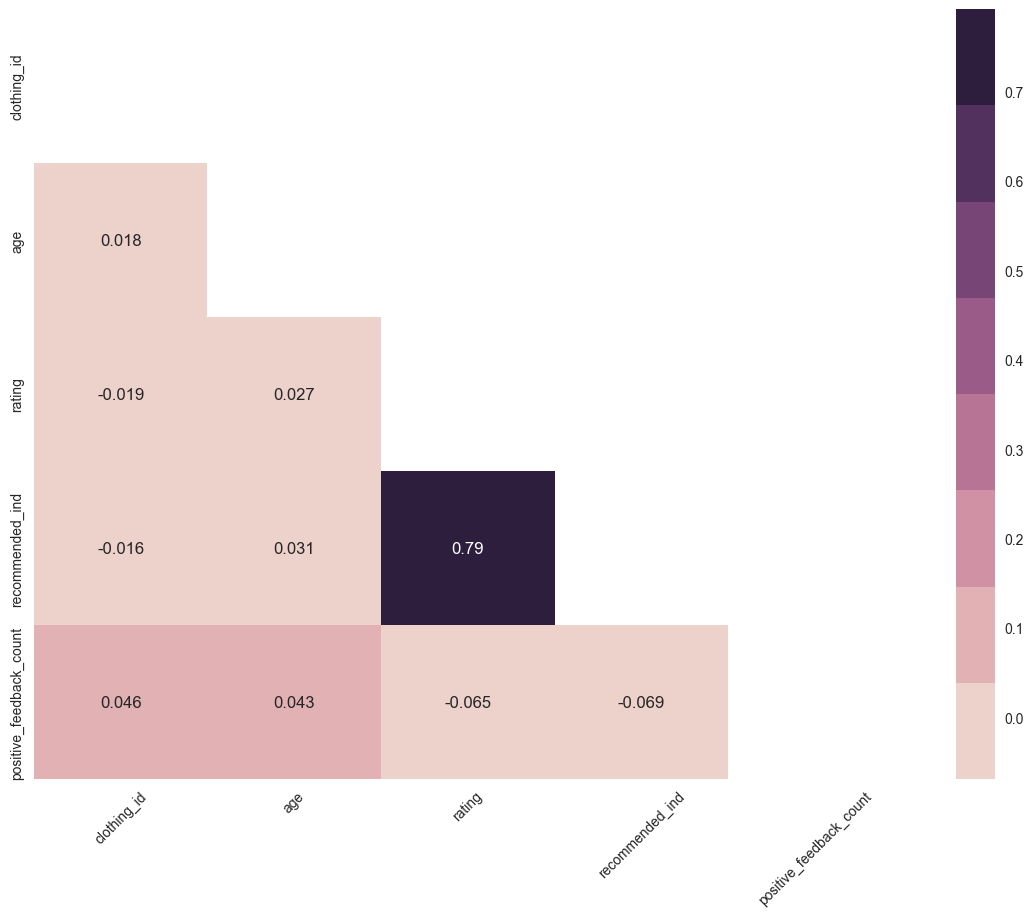

In [22]:
plt.figure(figsize=(14, 10))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(df.corr())

# using the upper triangle matrix as mask 
sns.heatmap(df.corr(), annot=True, cmap = sns.cubehelix_palette(8), mask=matrix)

plt.xticks(rotation=45);

### 4.2 - The Examination of Target Variable 

In [23]:
df.columns

Index(['clothing_id', 'age', 'title', 'review_text', 'rating',
       'recommended_ind', 'positive_feedback_count', 'division_name',
       'department_name', 'class_name'],
      dtype='object')

Let's Check Proportion of Target Class Variable:

The target class variable is imbalanced, where "Recommended" values are more dominating then "Not Recommendation".

In [24]:
df["recommended_ind"].value_counts()

1    19314
0     4172
Name: recommended_ind, dtype: int64

In [25]:
df["recommended_ind"].value_counts()

1    19314
0     4172
Name: recommended_ind, dtype: int64

In [26]:
first_look("recommended_ind")

column name    :  recommended_ind
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
1    19314
0     4172
Name: recommended_ind, dtype: int64


In [27]:
df["recommended_ind"].describe().T

count   23486.00
mean        0.82
std         0.38
min         0.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: recommended_ind, dtype: float64

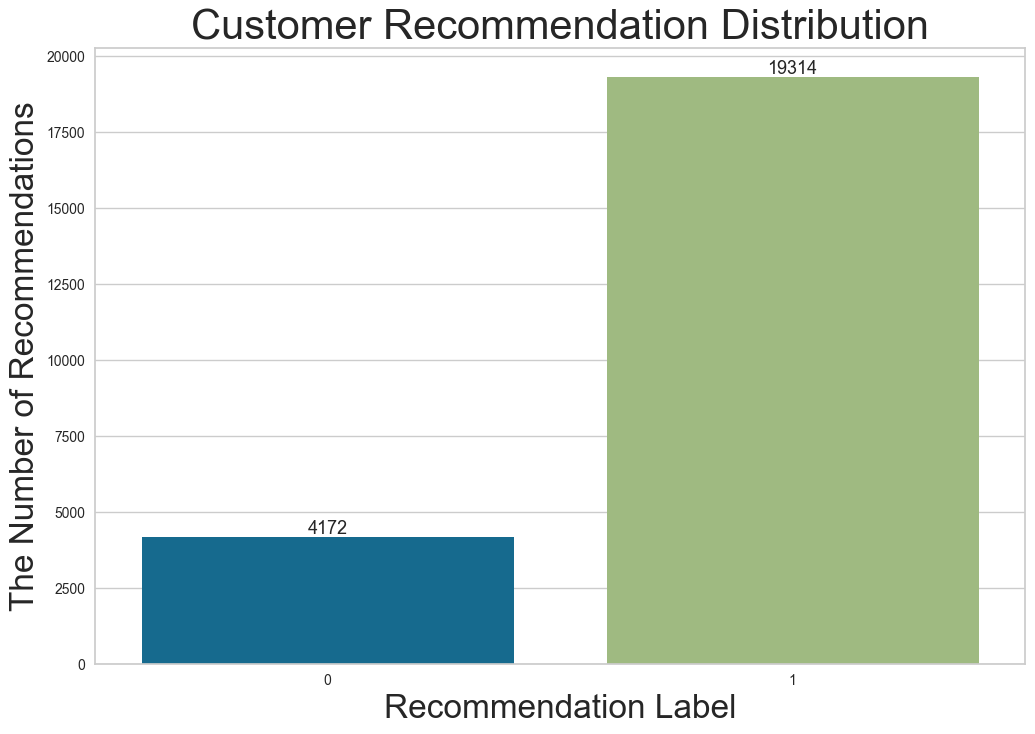

In [28]:
sns.countplot(x = df.recommended_ind, data = df)
plt.title('Customer Recommendation Distribution', fontsize=30)
plt.xlabel("Recommendation Label", fontsize=24)
plt.ylabel("The Number of Recommendations", fontsize=24)

for index,value in enumerate(df.recommended_ind.value_counts().sort_values()):
     plt.text(index, value, f"{value}", ha="center", va="bottom", fontsize = 13)

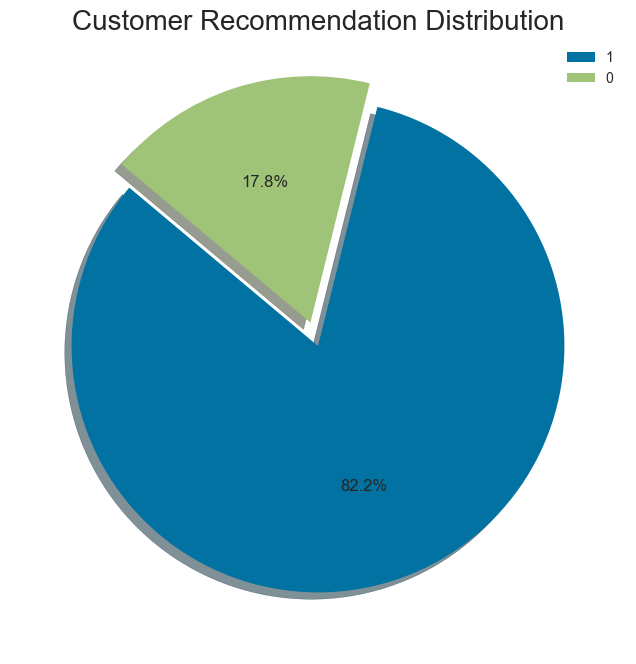

In [29]:
plt.figure(figsize=(8, 8))

explode = [0, 0.1]
plt.pie(df['recommended_ind'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=['1', '0'])
plt.title('Customer Recommendation Distribution', fontsize=20)
plt.axis('off');

As you noticed that the target variable, "recommended_ind", in this study is imblanced so this researcher will concentrate Recall score on evaluating the results rather than Accuracy score used in the evaluation of balanced data.

### 4.3 - The Examination of Other Features 

The Examination of "rating" Variable

"rating" is a Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.

In [30]:
df["rating"].value_counts()

5    13131
4     5077
3     2871
2     1565
1      842
Name: rating, dtype: int64

In [31]:
first_look("rating")

column name    :  rating
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  5
5    13131
4     5077
3     2871
2     1565
1      842
Name: rating, dtype: int64


In [32]:
df["rating"].describe().T

count   23486.00
mean        4.20
std         1.11
min         1.00
25%         4.00
50%         5.00
75%         5.00
max         5.00
Name: rating, dtype: float64

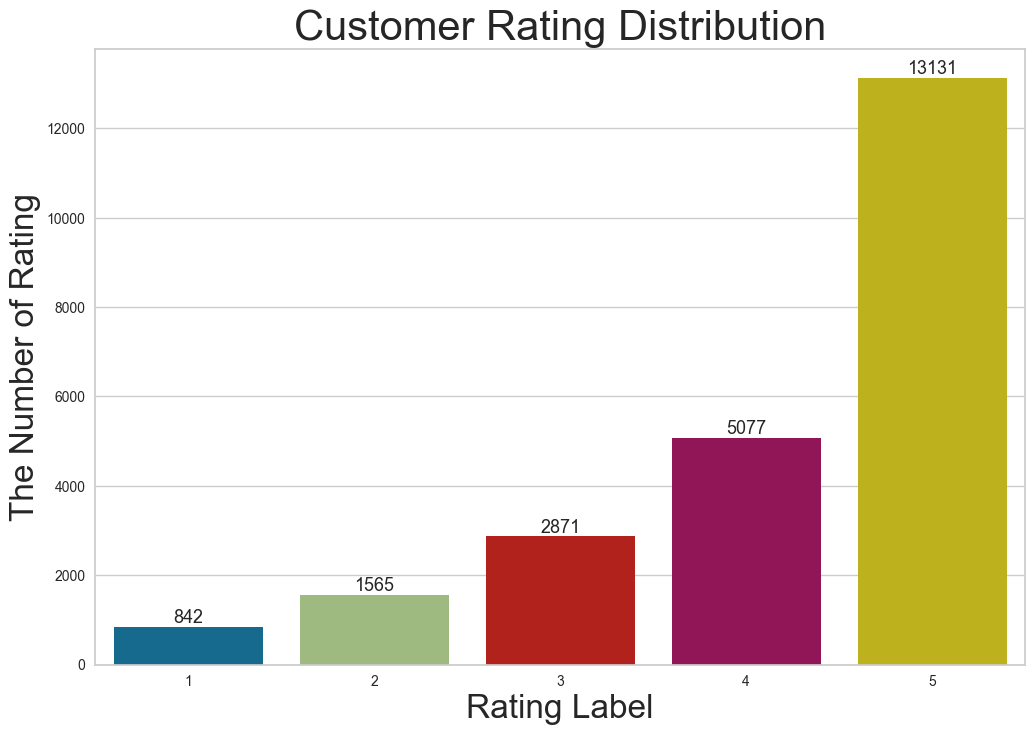

In [33]:
sns.countplot(x = df.rating, data = df)
plt.title('Customer Rating Distribution', fontsize=30)
plt.xlabel("Rating Label", fontsize=24)
plt.ylabel("The Number of Rating", fontsize=24)

for index,value in enumerate(df.rating.value_counts().sort_values()):
     plt.text(index, value, f"{value}", ha="center", va="bottom", fontsize = 13);

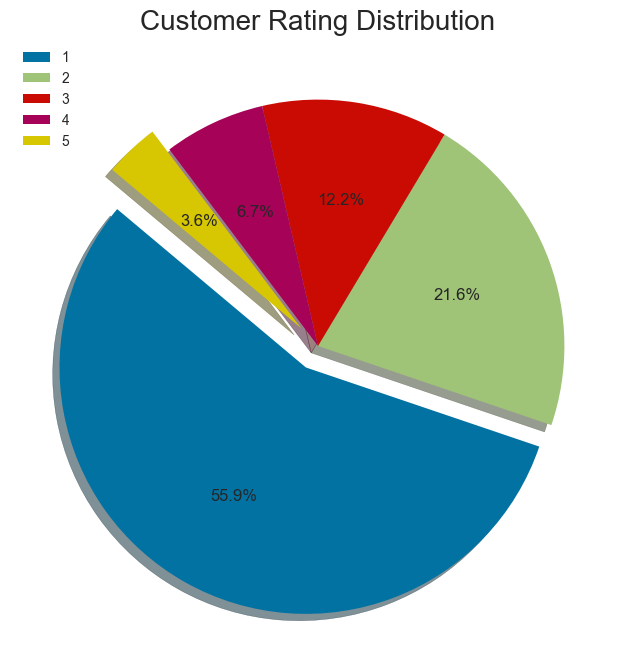

In [34]:
plt.figure(figsize=(8, 8))

explode = [0.1, 0, 0, 0, 0.1]
plt.pie(df['rating'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=['1', '2', '3', '4','5'])
plt.title('Customer Rating Distribution', fontsize=20)
plt.axis('off');

The Examination of "age" Variable

"age" is a Positive Integer variable of the reviewers age.

In [35]:
df["age"].value_counts()

39    1269
35     909
36     842
34     804
38     780
37     766
41     741
33     725
46     713
42     651
32     631
48     626
40     617
44     617
43     579
31     569
47     564
53     560
45     529
29     513
49     490
56     471
52     442
28     428
26     423
30     407
50     398
54     395
51     393
57     363
27     344
60     341
62     338
25     331
55     328
59     321
58     277
66     276
64     247
23     247
24     245
63     239
61     227
65     226
67     157
22     146
68     141
69     113
20     108
21     102
70      93
71      51
74      50
72      46
83      43
19      40
73      40
75      26
77      18
78      15
79      15
82      13
76      10
80      10
85       6
84       6
89       5
81       5
91       5
18       4
87       4
94       3
93       2
90       2
86       2
99       2
92       1
Name: age, dtype: int64

In [36]:
first_look("age")

column name    :  age
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  77
39    1269
35     909
36     842
34     804
38     780
37     766
41     741
33     725
46     713
42     651
32     631
48     626
40     617
44     617
43     579
31     569
47     564
53     560
45     529
29     513
49     490
56     471
52     442
28     428
26     423
30     407
50     398
54     395
51     393
57     363
27     344
60     341
62     338
25     331
55     328
59     321
58     277
66     276
64     247
23     247
24     245
63     239
61     227
65     226
67     157
22     146
68     141
69     113
20     108
21     102
70      93
71      51
74      50
72      46
83      43
19      40
73      40
75      26
77      18
78      15
79      15
82      13
76      10
80      10
85       6
84       6
89       5
81       5
91       5
18       4
87       4
94       3
93       2
90       2
86       2
99       2
92       1
Name: age, dtype: int64


In [37]:
df["age"].describe().T

count   23486.00
mean       43.20
std        12.28
min        18.00
25%        34.00
50%        41.00
75%        52.00
max        99.00
Name: age, dtype: float64

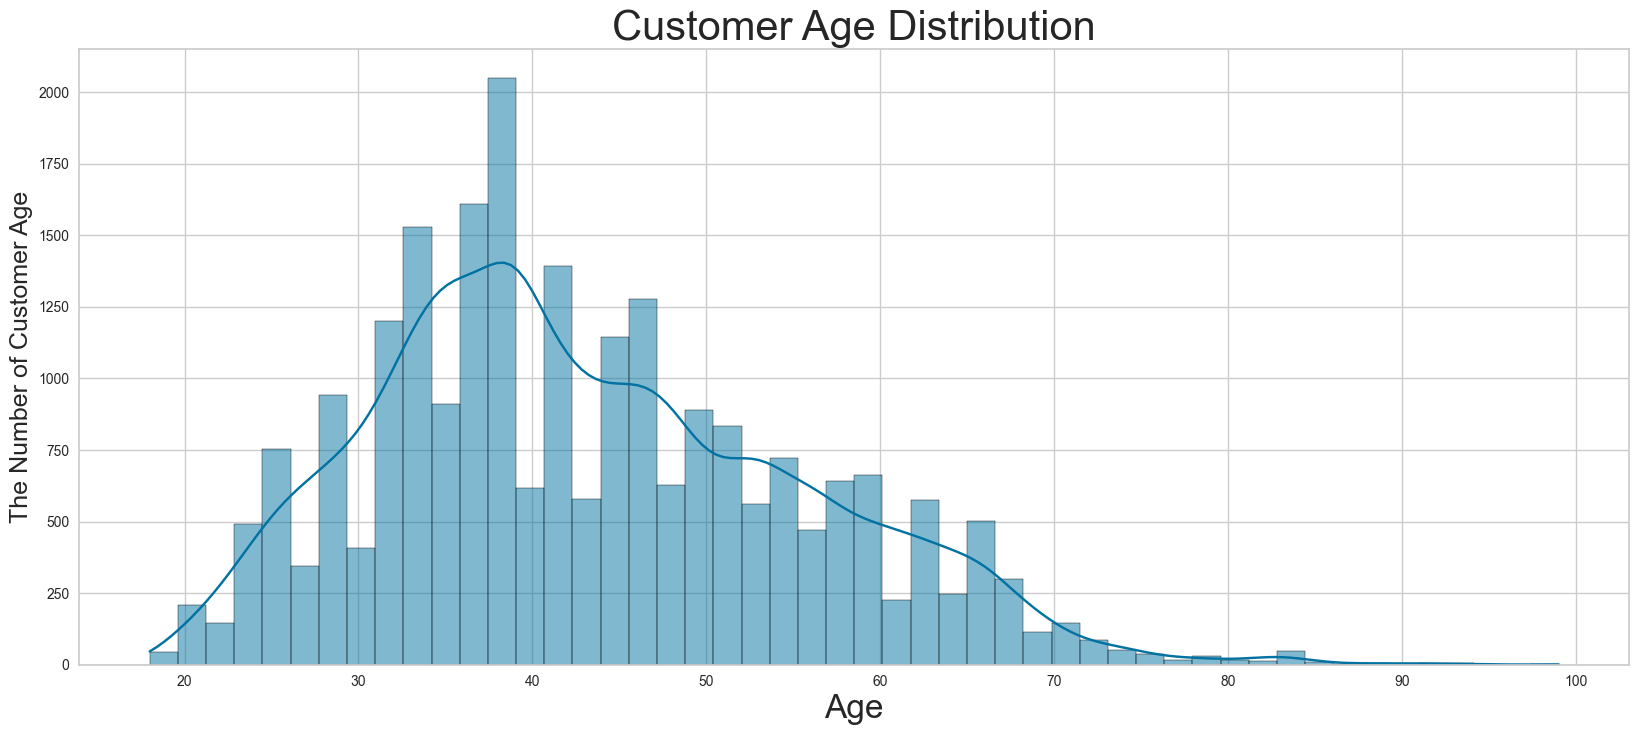

In [38]:
plt.figure(figsize = (20, 8))
plt.title('Customer Age Distribution', fontsize=30)
plt.xlabel("Age", fontsize=24)
plt.ylabel("The Number of Customer Age", fontsize=18)

sns.histplot(df, x='age', kde = True, bins = 50);

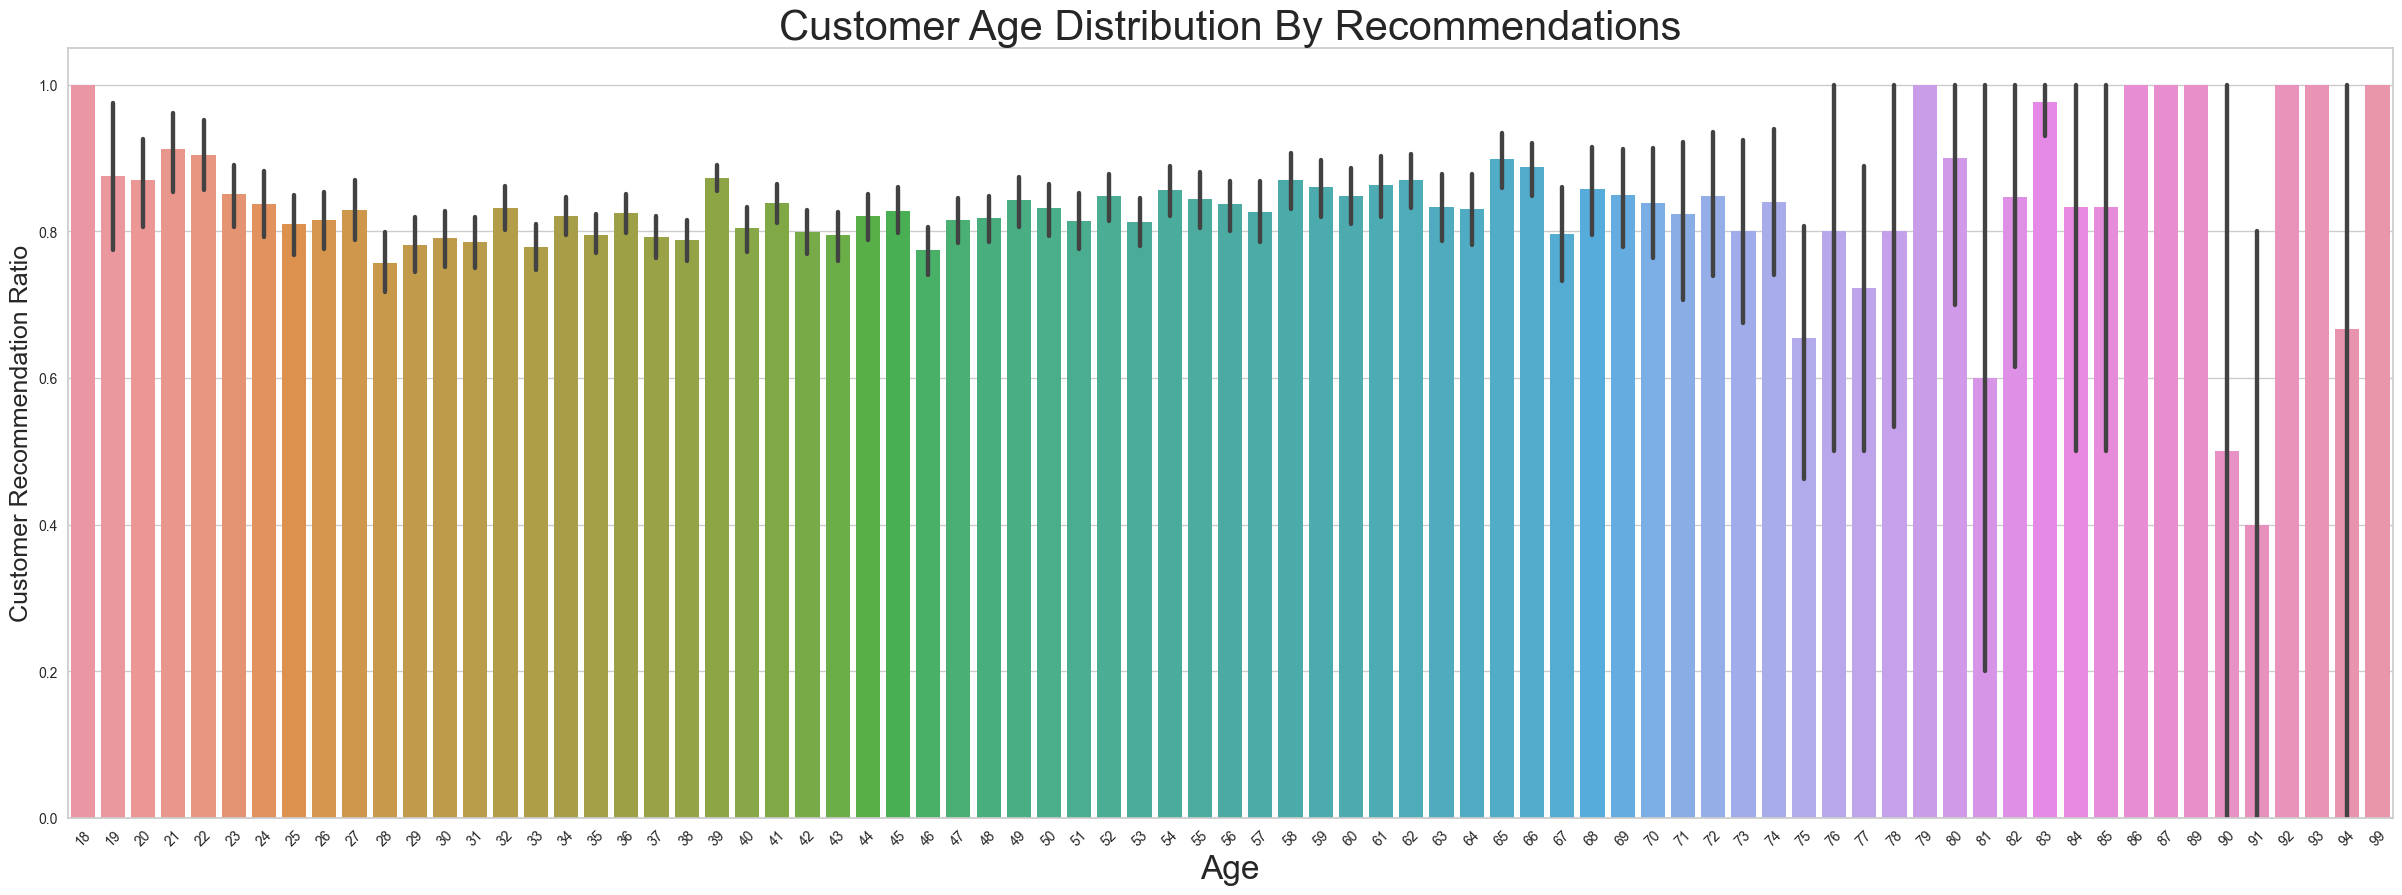

In [39]:
fig_dims = (30, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = df, x = "age", y = "recommended_ind", ax=ax)

plt.title('Customer Age Distribution By Recommendations', fontsize=30)
plt.xlabel("Age", fontsize=24)
plt.ylabel("Customer Recommendation Ratio", fontsize=18)
plt.xticks(rotation = 45);

In [40]:
fig = px.histogram(df['age'], color=df['recommended_ind'],
                   labels={'value': 'Age', 'color': 'Recommended'}, 
                   color_discrete_map={0: "magenta", 1: "MediumPurple"},
                   marginal='box')
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the Age and Recommendation',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='overlay')
fig.show()

The Examination of "positive_feedback_count" Variable

"positive_feedback_count" is Positive Integer documenting the number of other customers who found this review positive.

In [41]:
df["positive_feedback_count"].value_counts()

0      11176
1       4043
2       2193
3       1433
4        922
5        673
6        525
7        374
8        319
9        261
10       225
11       178
12       146
14       121
13       102
15        94
17        81
16        74
18        62
19        54
20        40
23        31
21        30
22        29
25        25
28        24
26        23
24        21
27        20
30        18
31        17
29        15
32        10
42         9
37         9
38         8
34         7
35         6
36         6
33         6
51         5
81         4
45         4
39         4
65         4
43         4
40         3
47         3
57         3
41         3
44         3
53         2
49         2
46         2
58         2
55         2
64         1
89         1
68         1
56         1
48         1
98         1
93         1
95         1
50         1
99         1
87         1
69         1
66         1
54         1
108        1
122        1
52         1
78         1
82         1
61         1
77         1

In [42]:
first_look("positive_feedback_count")

column name    :  positive_feedback_count
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  82
0      11176
1       4043
2       2193
3       1433
4        922
5        673
6        525
7        374
8        319
9        261
10       225
11       178
12       146
14       121
13       102
15        94
17        81
16        74
18        62
19        54
20        40
23        31
21        30
22        29
25        25
28        24
26        23
24        21
27        20
30        18
31        17
29        15
32        10
42         9
37         9
38         8
34         7
35         6
36         6
33         6
51         5
81         4
45         4
39         4
65         4
43         4
40         3
47         3
57         3
41         3
44         3
53         2
49         2
46         2
58         2
55         2
64         1
89         1
68         1
56         1
48         1
98         1
93         1
95         1
50         1
99         1
87

In [43]:
df["positive_feedback_count"].describe().T

count   23486.00
mean        2.54
std         5.70
min         0.00
25%         0.00
50%         1.00
75%         3.00
max       122.00
Name: positive_feedback_count, dtype: float64

<AxesSubplot:title={'center':'Customer Positive Feedback Distribution'}, xlabel='Customer Positive Feedback', ylabel='The Number of Customer Positive Feedback'>

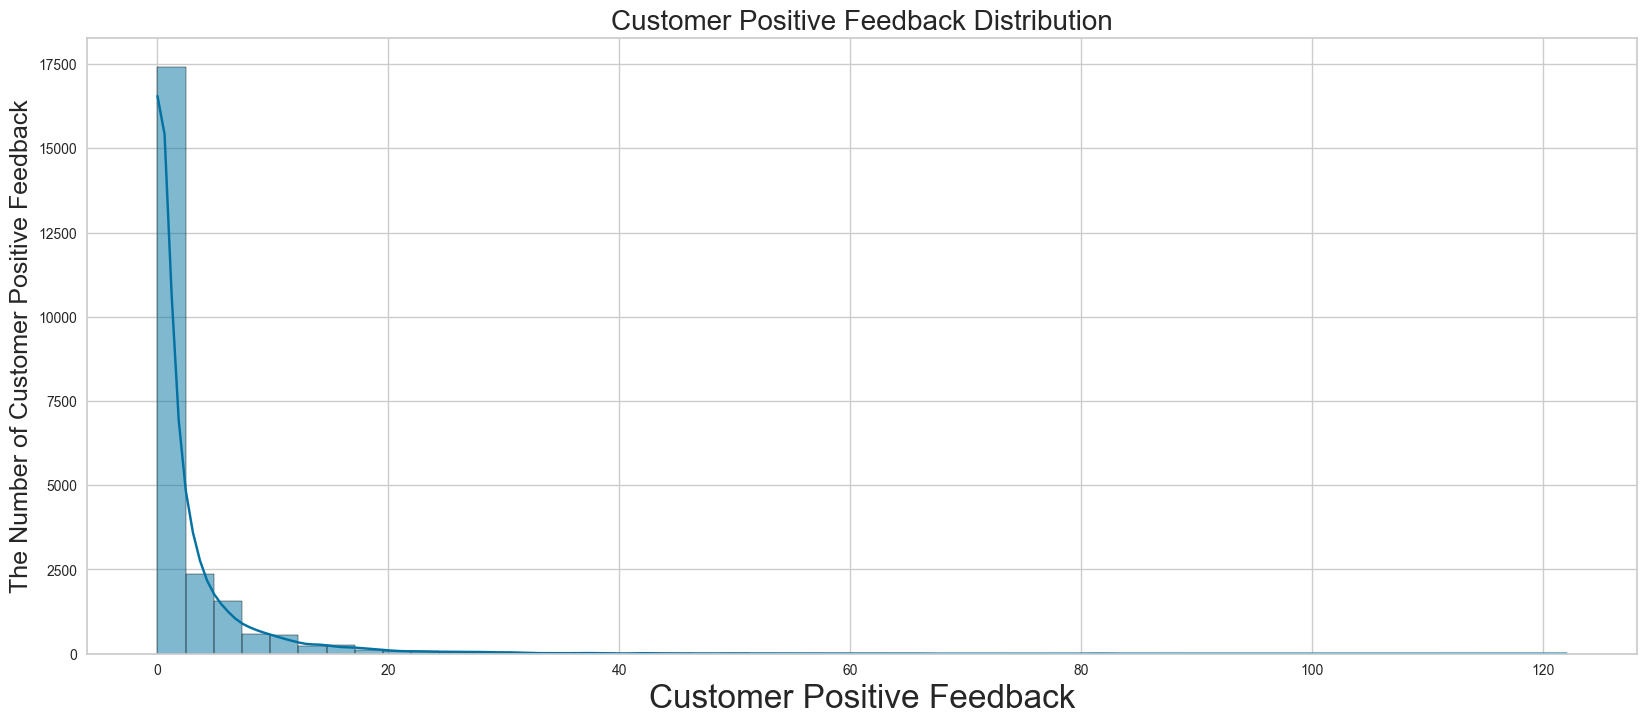

In [44]:
plt.figure(figsize = (20, 8))
plt.title('Customer Positive Feedback Distribution', fontsize=20)
plt.xlabel("Customer Positive Feedback", fontsize=24)
plt.ylabel("The Number of Customer Positive Feedback", fontsize=18)

sns.histplot(df, x='positive_feedback_count', kde = True, bins = 50)

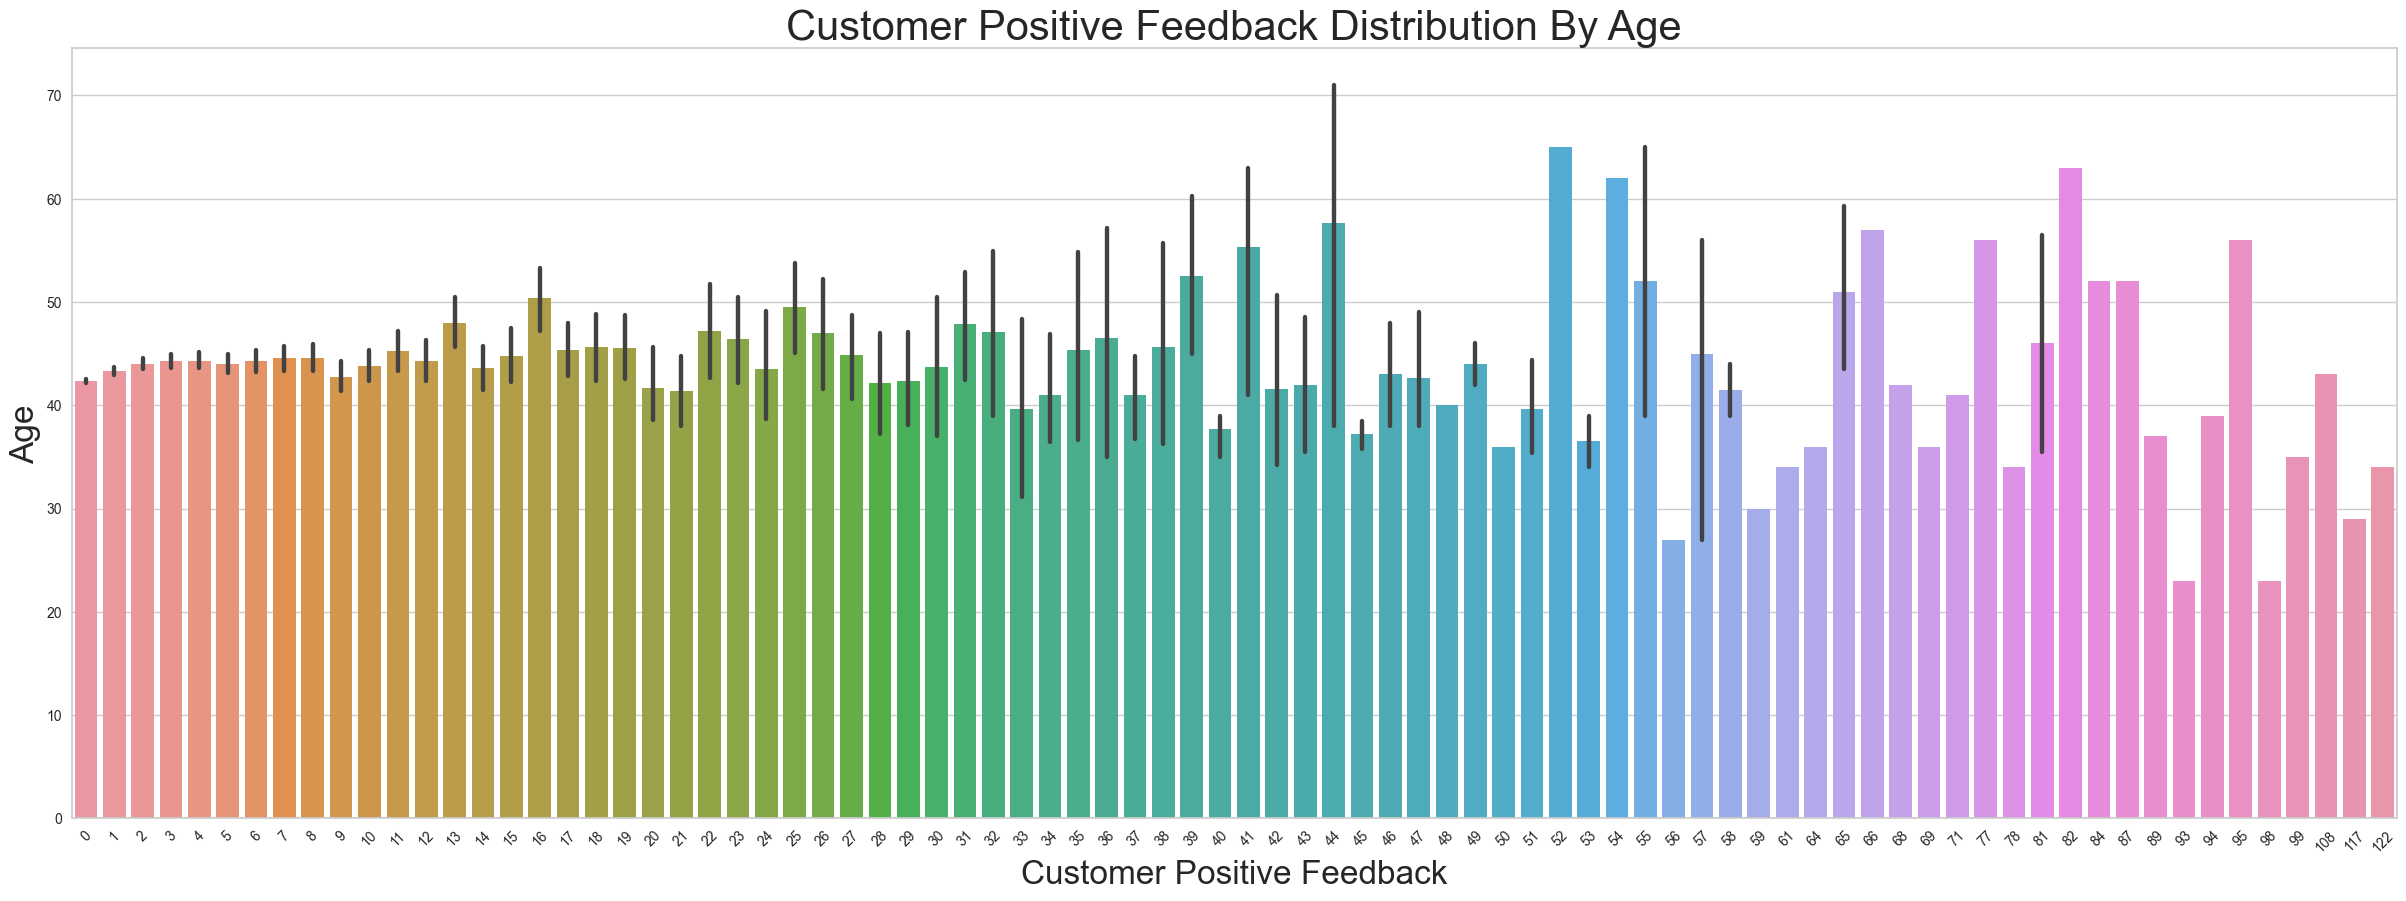

In [45]:
fig_dims = (30, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = df, x = "positive_feedback_count", y = "age", ax=ax)

plt.xlabel("Customer Positive Feedback", fontsize=24)
plt.ylabel("Age", fontsize=24)

plt.title('Customer Positive Feedback Distribution By Age', fontsize=30)
plt.xticks(rotation = 45)

The Examination of "division_name" Variable

"division_name" is Categorical name of the product high level division.

In [46]:
df["division_name"].value_counts()

General           13850
General Petite     8120
Initmates          1502
Name: division_name, dtype: int64

In [47]:
first_look("division_name")

column name    :  division_name
--------------------------------
per_of_nulls   :  % 0.06
num_of_nulls   :  14
num_of_uniques :  3
General           13850
General Petite     8120
Initmates          1502
NaN                  14
Name: division_name, dtype: int64


In [48]:
df["division_name"].describe().T

count       23472
unique          3
top       General
freq        13850
Name: division_name, dtype: object

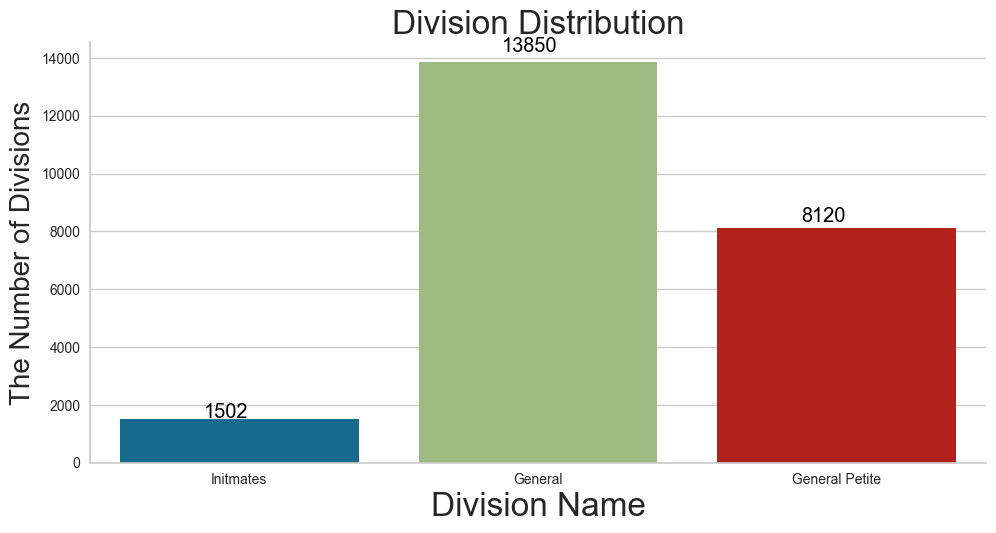

In [49]:
g = sns.catplot( x='division_name',
             kind="count", 
             data=df,
             height=5,
             aspect=2)

plt.title('Division Distribution', fontsize=24)
plt.xlabel("Division Name", fontsize=24)
plt.ylabel("The Number of Divisions", fontsize=20)

ax = g.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.28, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

plt.show()

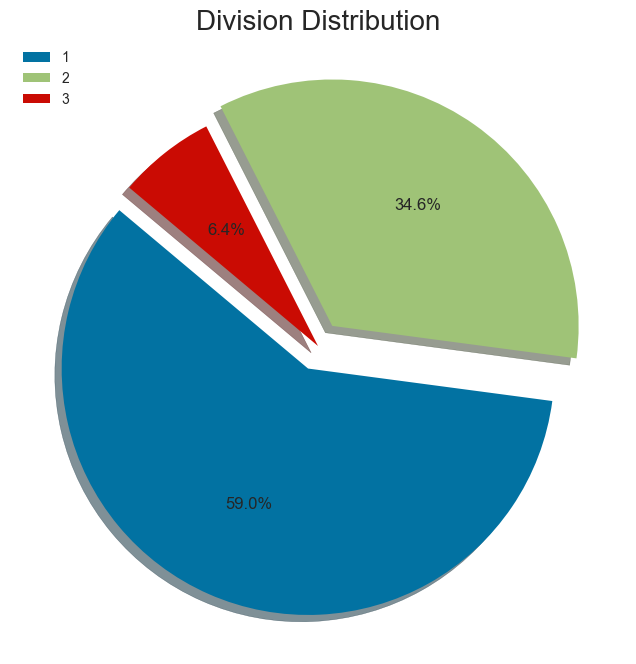

In [50]:
plt.figure(figsize=(8, 8))

explode = [0.1, 0.1, 0]
plt.pie(df['division_name'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=['1', '2', '3'])
plt.title('Division Distribution', fontsize=20)
plt.axis('off');

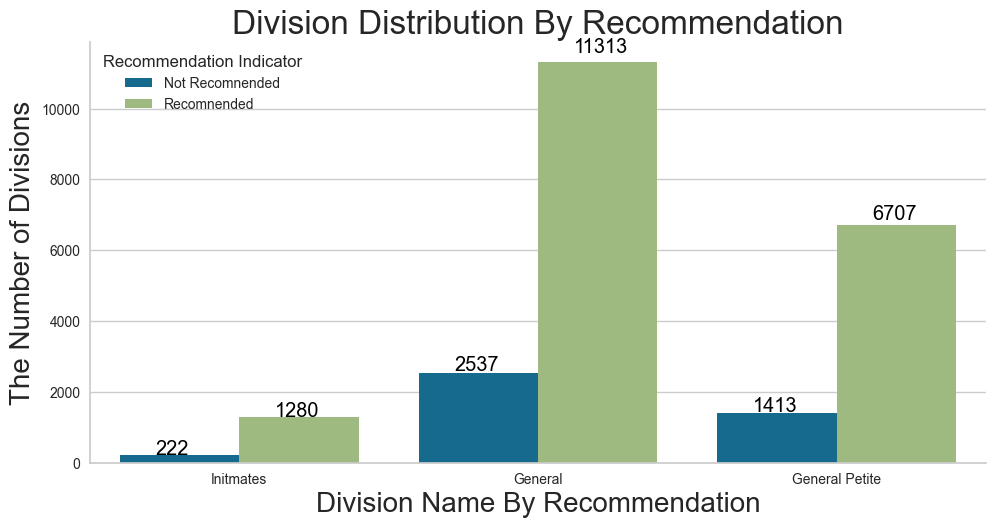

In [51]:
g = sns.catplot(data = df, x ="division_name", hue = "recommended_ind", kind='count', height=5, aspect=2, legend_out=False)

plt.title('Division Distribution By Recommendation', fontsize=24)
plt.xlabel("Division Name By Recommendation", fontsize=20)
plt.ylabel("The Number of Divisions", fontsize=20)
plt.legend(title='Recommendation Indicator', loc='upper left', labels=['Not Recomnended', 'Recomnended'])

ax = g.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.12, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

plt.show()

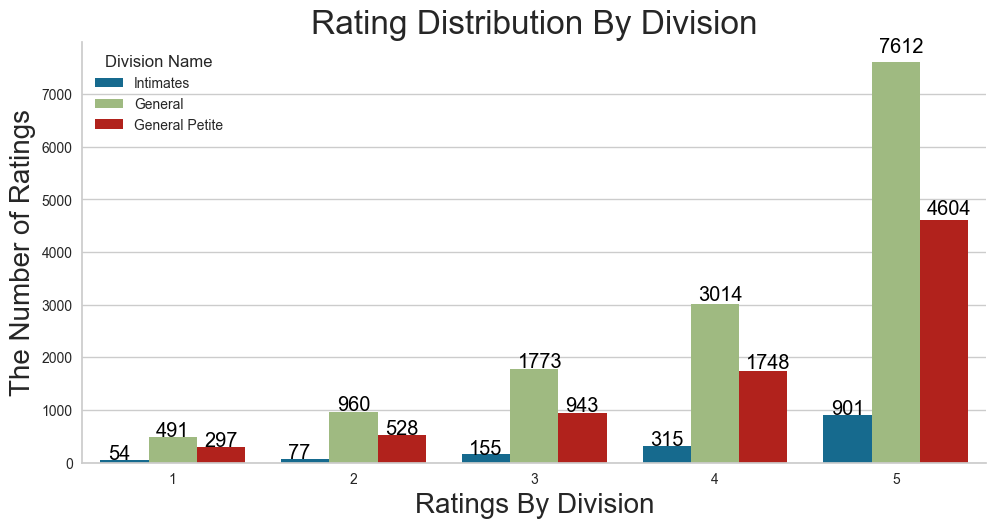

In [52]:
g = sns.catplot(data = df, x ="rating", hue = "division_name", kind='count', height=5, aspect=2, legend_out=False)

plt.title('Rating Distribution By Division', fontsize=24)
plt.xlabel("Ratings By Division", fontsize=20)
plt.ylabel("The Number of Ratings", fontsize=20)
plt.legend(title='Division Name', loc='upper left', labels=['Intimates', 'General', 'General Petite'])

ax = g.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.04, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

plt.show()

The Examination of "department_name" Variable

"department_name" is a Categorical variable of the product department name.

In [53]:
df["department_name"].value_counts()

Tops        10468
Dresses      6319
Bottoms      3799
Intimate     1735
Jackets      1032
Trend         119
Name: department_name, dtype: int64

In [54]:
first_look("department_name")

column name    :  department_name
--------------------------------
per_of_nulls   :  % 0.06
num_of_nulls   :  14
num_of_uniques :  6
Tops        10468
Dresses      6319
Bottoms      3799
Intimate     1735
Jackets      1032
Trend         119
NaN            14
Name: department_name, dtype: int64


In [55]:
df["department_name"].describe().T

count     23472
unique        6
top        Tops
freq      10468
Name: department_name, dtype: object

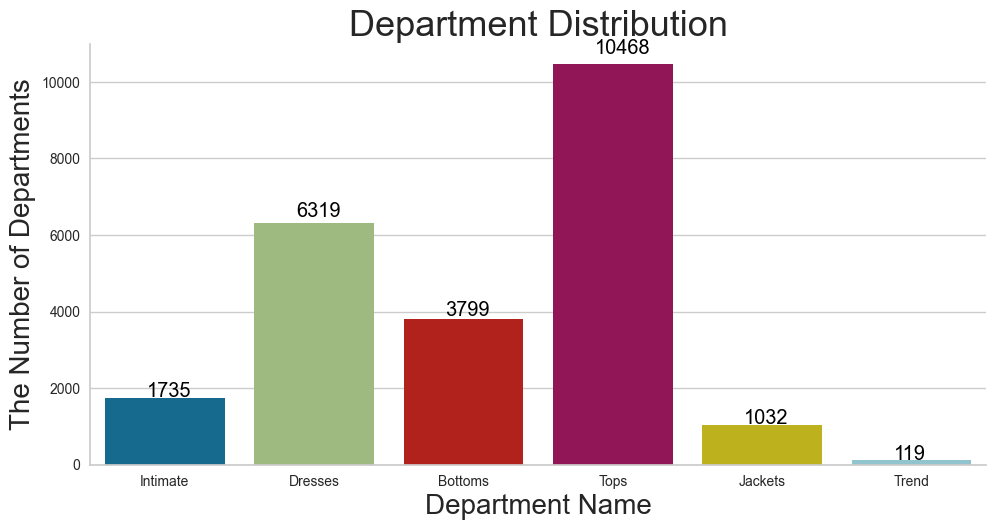

In [56]:
g = sns.catplot(data = df, x ="department_name", kind='count', height=5, aspect=2)

plt.title('Department Distribution', fontsize=26)
plt.xlabel("Department Name", fontsize=20)
plt.ylabel("The Number of Departments", fontsize=20)

ax = g.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.28, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

plt.show()

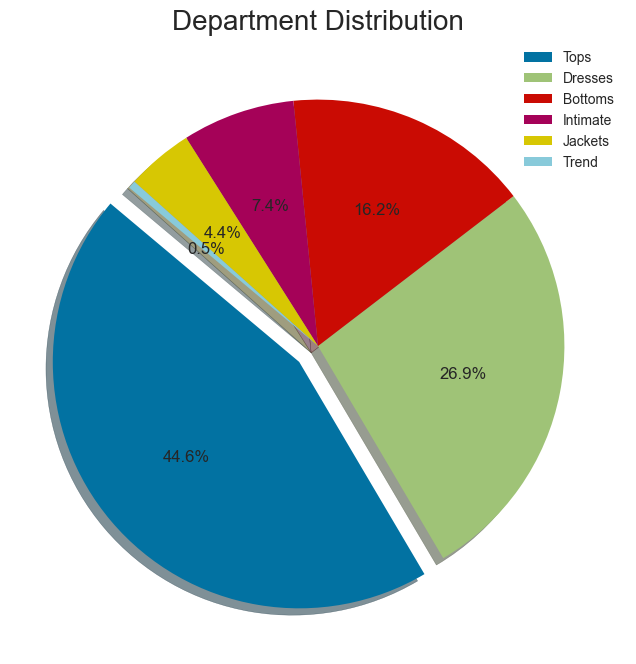

In [57]:
plt.figure(figsize=(8, 8))

explode = [0.1, 0, 0, 0, 0, 0]
plt.pie(df['department_name'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=['Tops', 'Dresses', 'Bottoms', 'Intimate', 'Jackets', 'Trend'])
plt.title('Department Distribution', fontsize=20)
plt.axis('off');

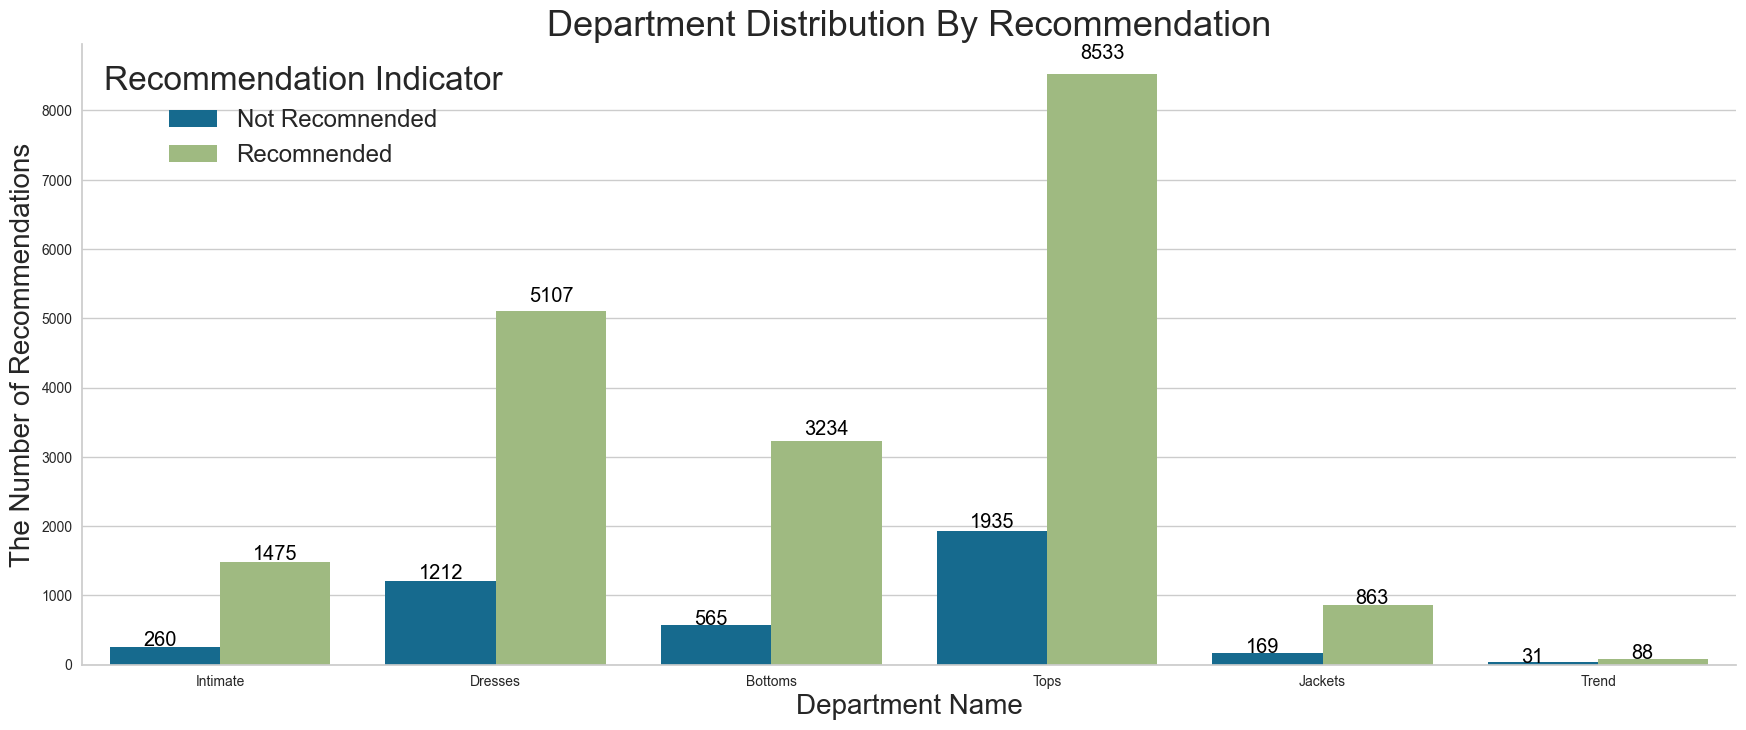

In [58]:
g = sns.catplot(data = df, x ="department_name", hue = "recommended_ind", kind='count', height=7, aspect=2.5, legend_out=False)

plt.title('Department Distribution By Recommendation', fontsize=26)
plt.xlabel("Department Name", fontsize=20)
plt.ylabel("The Number of Recommendations", fontsize=20)
plt.legend(title='Recommendation Indicator', loc='upper left', labels=['Not Recomnended', 'Recomnended'], fontsize='x-large', title_fontsize='24')

ax = g.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.12, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

plt.show()

<Figure size 1500x800 with 0 Axes>

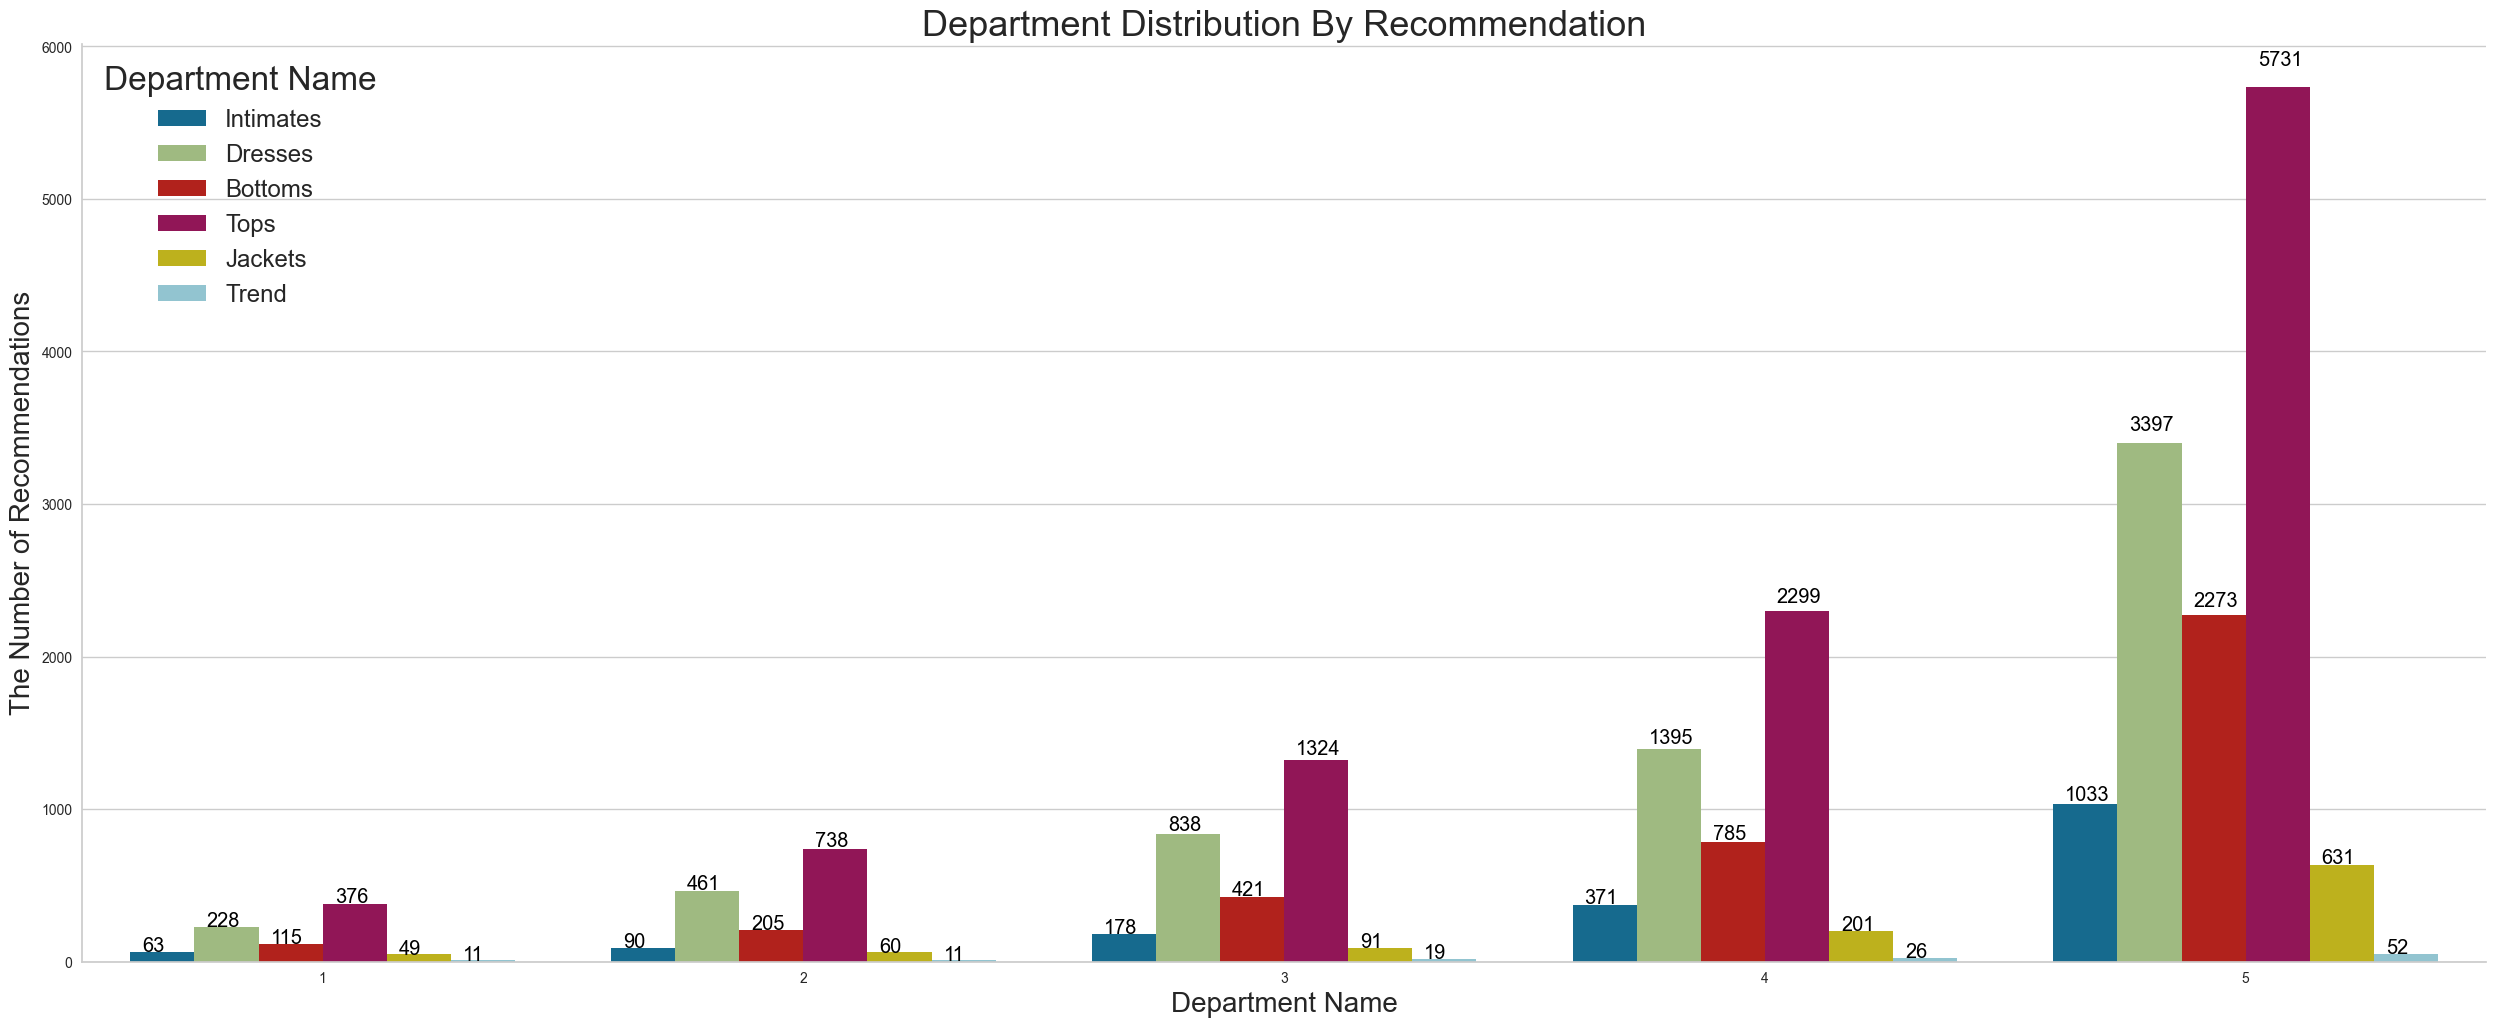

In [59]:
g = sns.catplot(data = df, x ="rating", hue = "department_name", kind='count', height=10, aspect=2.5, legend_out=False)

plt.title('Department Distribution By Recommendation', fontsize=26)
plt.xlabel("Department Name", fontsize=20)
plt.ylabel("The Number of Recommendations", fontsize=20)
plt.legend(title='Department Name', loc='upper left', labels=['Intimates', 'Dresses', 'Bottoms', 'Tops', 'Jackets', 'Trend'], fontsize='x-large', title_fontsize='24')
plt.figure(figsize=(15, 8))

ax = g.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.025, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

plt.show()

The Examination of "class_name" Variable

"class_name" is a Categorical variable of the product class name.

In [60]:
df["class_name"].value_counts()

Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1147
Fine gauge        1100
Skirts             945
Jackets            704
Lounge             691
Swim               350
Outerwear          328
Shorts             317
Sleep              228
Legwear            165
Intimates          154
Layering           146
Trend              119
Casual bottoms       2
Chemises             1
Name: class_name, dtype: int64

In [61]:
first_look("class_name")

column name    :  class_name
--------------------------------
per_of_nulls   :  % 0.06
num_of_nulls   :  14
num_of_uniques :  20
Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1147
Fine gauge        1100
Skirts             945
Jackets            704
Lounge             691
Swim               350
Outerwear          328
Shorts             317
Sleep              228
Legwear            165
Intimates          154
Layering           146
Trend              119
NaN                 14
Casual bottoms       2
Chemises             1
Name: class_name, dtype: int64


In [62]:
df["class_name"].describe().T

count       23472
unique         20
top       Dresses
freq         6319
Name: class_name, dtype: object

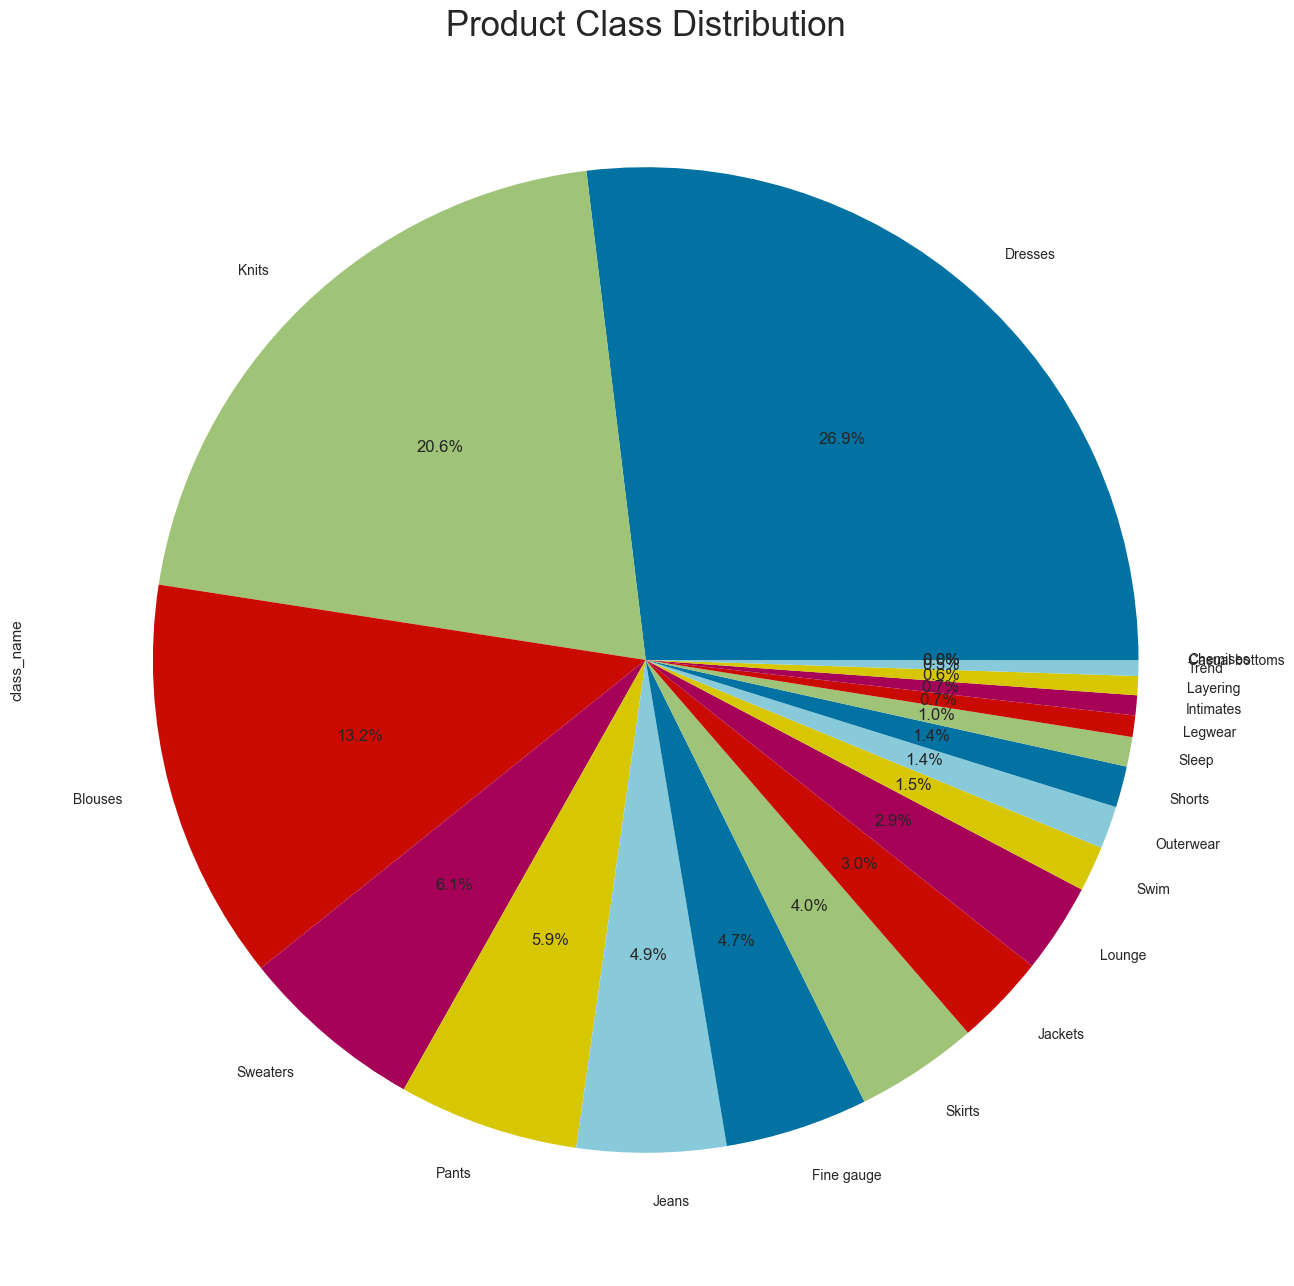

In [63]:
plt.title('Product Class Distribution', fontsize=25)
df["class_name"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(16, 16));

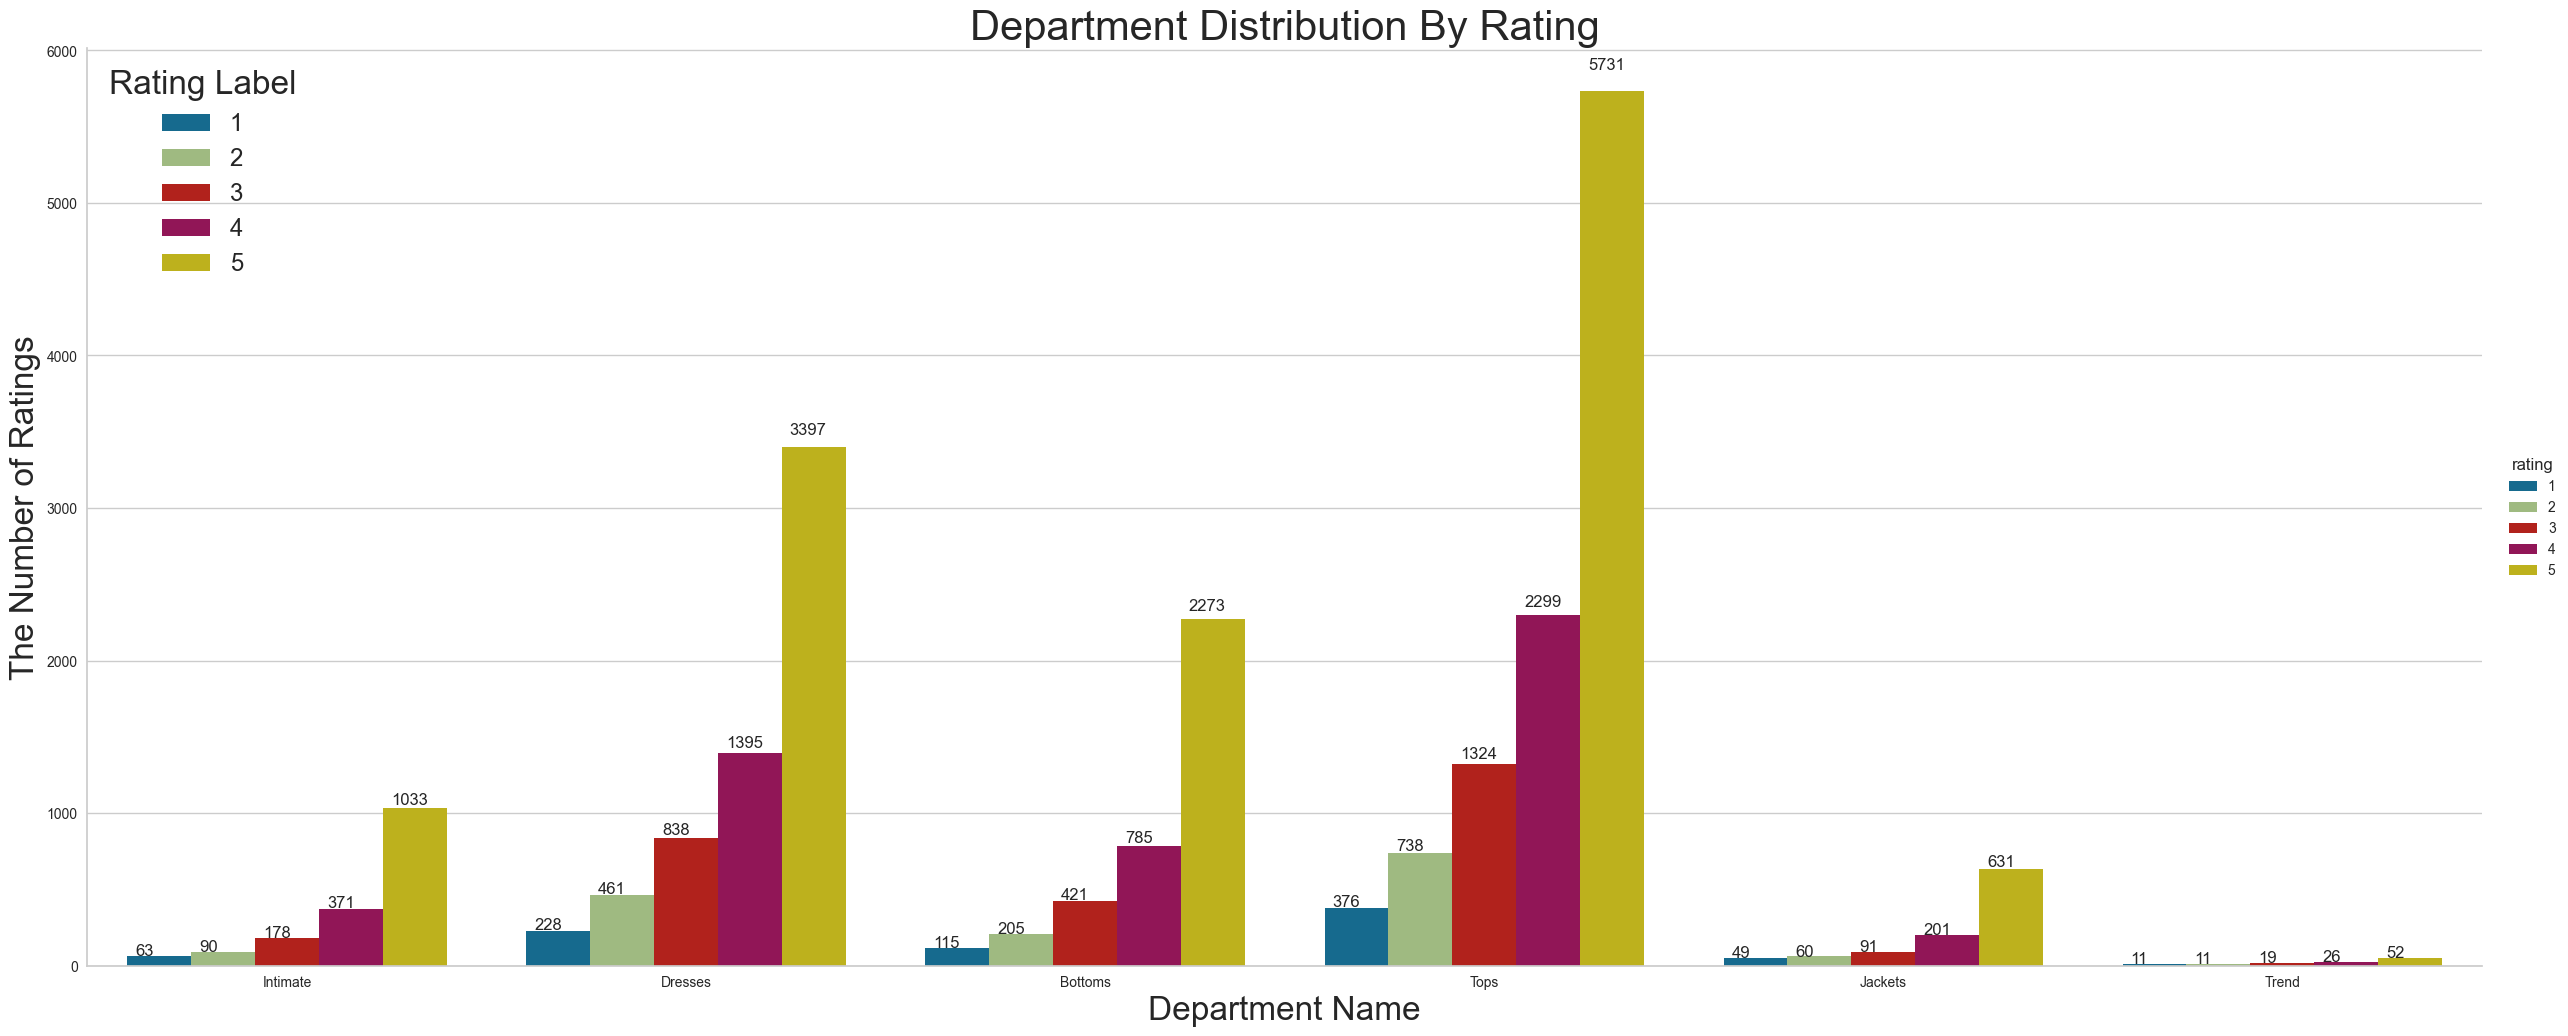

In [64]:
g = sns.catplot(data = df, x ="department_name", hue = "rating", kind='count', height=10, aspect=2.5)

sns.set(rc = {'figure.figsize':(30, 12)})
plt.title('Department Distribution By Rating', fontsize=30)
plt.xlabel("Department Name", fontsize=24)
plt.ylabel("The Number of Ratings", fontsize=24)
plt.legend(title='Rating Label', loc='upper left', labels=['1', '2', '3', '4', '5'], fontsize='x-large', title_fontsize='24')

ax = g.facet_axis(0, 0)
for p in ax.patches:
    ax.text(p.get_x() + 0.02, 
            p.get_height() * 1.025, 
            '{0:.0f}'.format(p.get_height()), 
    )

plt.show()

In [65]:
FreqOfWords = df['review_text'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0, width=1000, height=600)
fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (Before Cleaning)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

Let's create categorical and numerical sets for the examination of crosstab information.

In [66]:
df_cat = df[['division_name', 'department_name', 'class_name', "recommended_ind"]]
df_cat["recommended_ind"] = df_cat["recommended_ind"].apply(lambda x: "Recommended" if x>=1 else "Not Recommended")
df_cat.rename({'division_name': 'Division Name', 'department_name': 'Department Name', 'class_name': 'Class Name', 'recommended_ind': 'Recommendation Indicator'}, axis=1, inplace=True)
df_cat

Division Name Department Name Class Name Recommendation Indicator
0           Initmates        Intimate  Intimates              Recommended
1             General         Dresses    Dresses              Recommended
2             General         Dresses    Dresses          Not Recommended
3      General Petite         Bottoms      Pants              Recommended
4             General            Tops    Blouses              Recommended
...               ...             ...        ...                      ...
23481  General Petite         Dresses    Dresses              Recommended
23482  General Petite            Tops      Knits              Recommended
23483  General Petite         Dresses    Dresses          Not Recommended
23484         General         Dresses    Dresses              Recommended
23485  General Petite         Dresses    Dresses              Recommended

[23486 rows x 4 columns]

In [67]:
df_num = df[['age', 'rating', 'positive_feedback_count', 'recommended_ind']]
df_num["recommended_ind"] = df_num["recommended_ind"].apply(lambda x: "Recommended" if x>=1 else "Not Recommended")
df_num.rename({'age': 'Age', 'rating': 'Rating', 'positive_feedback_count': 'Positive Feedback', 'recommended_ind': 'Recommendation Indicator'}, axis=1, inplace=True)
df_num

Age  Rating  Positive Feedback Recommendation Indicator
0       33       4                  0              Recommended
1       34       5                  4              Recommended
2       60       3                  0          Not Recommended
3       50       5                  0              Recommended
4       47       5                  6              Recommended
...    ...     ...                ...                      ...
23481   34       5                  0              Recommended
23482   48       3                  0              Recommended
23483   31       3                  1          Not Recommended
23484   28       3                  2              Recommended
23485   52       5                 22              Recommended

[23486 rows x 4 columns]

In [68]:
for i, col in enumerate(df_cat.columns):
    xtab = pd.crosstab(df_cat[col], df_cat["Recommendation Indicator"], normalize=True)
    print(colored('-'*55, 'red', attrs=['bold']), sep='')
    print(xtab*100)

-------------------------------------------------------
Recommendation Indicator  Not Recommended  Recommended
Division Name                                         
General                             10.81        48.20
General Petite                       6.02        28.57
Initmates                            0.95         5.45
-------------------------------------------------------
Recommendation Indicator  Not Recommended  Recommended
Department Name                                       
Bottoms                              2.41        13.78
Dresses                              5.16        21.76
Intimate                             1.11         6.28
Jackets                              0.72         3.68
Tops                                 8.24        36.35
Trend                                0.13         0.37
-------------------------------------------------------
Recommendation Indicator  Not Recommended  Recommended
Class Name                                            
Blouses

In [69]:
for i, col in enumerate(df_num.columns):
    xtab = pd.crosstab(df_num[col], df_num["Recommendation Indicator"], normalize=True)
    print(colored('-'*55, 'red', attrs=['bold']), sep='')
    print(xtab*100)

-------------------------------------------------------
Recommendation Indicator  Not Recommended  Recommended
Age                                                   
18                                   0.00         0.02
19                                   0.02         0.15
20                                   0.06         0.40
21                                   0.04         0.40
22                                   0.06         0.56
23                                   0.16         0.89
24                                   0.17         0.87
25                                   0.27         1.14
26                                   0.33         1.47
27                                   0.25         1.21
28                                   0.44         1.38
29                                   0.48         1.71
30                                   0.36         1.37
31                                   0.52         1.90
32                                   0.45         2.24
33       

## 5.1 Feature Selection

In [70]:
df.columns

Index(['clothing_id', 'age', 'title', 'review_text', 'rating',
       'recommended_ind', 'positive_feedback_count', 'division_name',
       'department_name', 'class_name'],
      dtype='object')

For later parts of the analysis, we will drop unnecassary columns for NLP.

In [71]:
df.drop(['clothing_id', 'age', 'title', 'rating',
       'positive_feedback_count', 'division_name',
       'department_name', 'class_name'], axis=1, inplace=True)

In [72]:
df.head(3)

review_text  \
0                                                                                                                                                    Absolutely wonderful - silky and sexy and comfortable   
1  Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length...   
2  I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i co...   

   recommended_ind  
0                1  
1                1  
2                0

## 5.2 Detecting & Handling With Missing Values 

In [73]:
df['review_text'].isnull().value_counts()

False    22641
True       845
Name: review_text, dtype: int64

In [74]:
df['recommended_ind'].isnull().value_counts()

False    23486
Name: recommended_ind, dtype: int64

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review_text      22641 non-null  object
 1   recommended_ind  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


In [76]:
df = df.dropna()

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review_text      22641 non-null  object
 1   recommended_ind  22641 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 530.6+ KB


In [78]:
df['review_text'].isnull().value_counts()

False    22641
Name: review_text, dtype: int64

In [79]:
df['recommended_ind'].isnull().value_counts()

False    22641
Name: recommended_ind, dtype: int64

In [80]:
missing_values(df)

Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []

Sometimes we cannot detect missing values if they consist of empty (blank) string such as " ". In this situation we can use the following syntax.

In [81]:
blanks = []  # start with an empty list

for rv in df.itertuples(): # iterate over the DataFrame
    if type(rv)==str and rv.isspace(): # avoid NaN values and test 'review' for whitespace
        blanks.append(i)
blanks

[]

In [82]:
df["review_text"].str.isspace().sum()

0

In [83]:
df[df["review_text"].str.isspace() == True].index

Int64Index([], dtype='int64')

## 6) TEXT MINING 

Text is the most unstructured form of all the available data, therefore various types of noise are present in it. This means that the data is not readily analyzable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing.

The three key steps of text preprocessing:

Tokenization: This step is one of the top priorities when it comes to working on text mining. Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens.

Noise Removal: Any piece of text which is not relevant to the context of the data and the end-output can be specified as the noise. For example – language stopwords (commonly used words of a language – is, am, the, of, in etc), URLs or links, upper and lower case differentiation, punctuations and industry specific words. This step deals with removal of all types of noisy entities present in the text.

Lexicon Normalization: Another type of textual noise is about the multiple representations exhibited by single word. For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”. Though they mean different things, contextually they all are similar. This step converts all the disparities of a word into their normalized form (also known as lemma). There are two methods of lexicon normalisation; Stemming or Lemmatization. Lemmatization is recommended for this case, because Lemmatization as this will return the root form of each word (rather than just stripping suffixes, which is stemming).
As the first step change text to tokens and convertion all of the words to lower case. Next remove punctuation, bad characters, numbers and stop words. The second step is aimed to normalization them throught the Lemmatization method.

Note: Use the functions of the **nltk Library** for all the above operations.

## 6.1 Tokenization, Noise Removal & Lexicon Normalization

We can use one of the following user defined functions for Tokenization, Noise Removal and Lexicon Normalization. Both do the same job. We prefered to implement the first one. It's depends on you which one you prefer.

In [84]:
def cleaning_fsa(data):
    
    import re
    #1. Remove Puncs
    # \w typically matches [A-Za-z0-9_]
    text = re.sub('[^\w\s]','', data)
         
    #2. Tokenize
    text_tokens = word_tokenize(text.lower()) 
    
    #3. Remove numbers
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #5. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    #joining
    return " ".join(text_cleaned)

In [85]:
stop_words = stopwords.words('english')

In [86]:
text = cleaning_fsa(str(df["review_text"]))
text

'absolutely wonderful silky sexy comfortable love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact co love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment shirt flattering due adjustable front tie perfect length wear legging sleeveless pair well cardigan love shirt happy snag dress great price easy slip flattering cut color combo reminds maternity clothes soft stretchy shiny material cut flattering drape nicely found one button close front looked awkward nice long sleevesnnot bu fit well top see never would worked im glad able try store didnt order online different fabric would bought dress wedding summer cute unfortunately fit isnt perfect medium fit waist perfectly way long big bust sh dress lovely platinum feminine fit perfectly easy wear comfy highly recommend name length d

In [87]:
df["review_text"] = df["review_text"].apply(cleaning_fsa)
df["review_text"].head()

0                                                                                                                                                                absolutely wonderful silky sexy comfortable
1                       love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite
2    high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom...
3                                                                                                                   love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment
4                                                                                             shirt flattering due adjustable front tie perfect length wear legging sleeveless pair 

In [88]:
df.head(3)

review_text  \
0                                                                                                                                                              absolutely wonderful silky sexy comfortable   
1                     love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite   
2  high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom...   

   recommended_ind  
0                1  
1                1  
2                0

## 6.2 Handling With Rare Words

In [89]:
" ".join(df["review_text"]).split()

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 'im',
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc',
 'petite',
 'bought',
 'petite',
 'love',
 'length',
 'hit',
 'little',
 'knee',
 'would',
 'definitely',
 'true',
 'midi',
 'someone',
 'truly',
 'petite',
 'high',
 'hope',
 'dress',
 'really',
 'wanted',
 'work',
 'initially',
 'ordered',
 'petite',
 'small',
 'usual',
 'size',
 'found',
 'outrageously',
 'small',
 'small',
 'fact',
 'could',
 'zip',
 'reordered',
 'petite',
 'medium',
 'ok',
 'overall',
 'top',
 'half',
 'comfortable',
 'fit',
 'nicely',
 'bottom',
 'half',
 'tight',
 'layer',
 'several',
 'somewhat',
 'cheap',
 'net',
 'layer',
 'imo',
 'major',
 'design',
 'flaw',
 'net',
 'layer',
 'sewn',
 'directly',
 'zipper',
 'c',
 'love',
 'love',
 'love',
 'jumpsuit',
 'fun',
 'flirty',
 'fabulous',
 'every',
 'time',
 'wear',
 'get',
 'nothing',
 'great',
 'complimen

In [90]:
word_values = pd.Series(" ".join(df["review_text"]).split()).value_counts()
word_values

dress       11319
fit         10091
size         9349
love         8968
top          8256
            ...  
takeout         1
teenybop        1
hugely          1
shirred         1
platinum        1
Length: 16758, dtype: int64

In [91]:
rare_words = word_values[word_values <= 2]
rare_words

wristforearm    2
magnolia        2
smalltight      2
urban           2
underrated      2
               ..
takeout         1
teenybop        1
hugely          1
shirred         1
platinum        1
Length: 10935, dtype: int64

In [92]:
rare_words.value_counts()

1    9058
2    1877
dtype: int64

In [93]:
len(rare_words)

10935

In [94]:
rare_words.index

Index(['wristforearm', 'magnolia', 'smalltight', 'urban', 'underrated',
       'henleys', 'greenyellow', 'outrageous', 'blueteal', 'status',
       ...
       'quaiity', 'befo', 'slam', 'brokenin', 'accomadate', 'takeout',
       'teenybop', 'hugely', 'shirred', 'platinum'],
      dtype='object', length=10935)

In [95]:
df["review_text"] = df["review_text"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))
df["review_text"].head()

0                                                                                                                                                                absolutely wonderful silky sexy comfortable
1                       love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite
2    high hope dress really wanted work initially ordered petite small usual size found small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight l...
3                                                                                                                   love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment
4                                                                                             shirt flattering due adjustable front tie perfect length wear legging sleeveless pair 

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review_text      22641 non-null  object
 1   recommended_ind  22641 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 530.6+ KB


In [97]:
df.head(3)

review_text  \
0                                                                                                                                                              absolutely wonderful silky sexy comfortable   
1                     love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite   
2  high hope dress really wanted work initially ordered petite small usual size found small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight l...   

   recommended_ind  
0                1  
1                1  
2                0

## 7) WORLDCLOUD - REPETITION OF WORDS 

Now we'll create a Word Clouds for reviews, representing most common words in each target class.

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud.

We are expected to create separate word clouds for positive and negative reviews. As such we can qualify a review as positive or negative, by looking at its recommended status.

We can follow the steps below:

Detect Reviews
Collect Words
Create Word Cloud

### 7.1 The Detection of Positive and Negative Reviews 

In [98]:
df.columns

Index(['review_text', 'recommended_ind'], dtype='object')

In [99]:
df[df["recommended_ind"] == 0]

review_text  \
2      high hope dress really wanted work initially ordered petite small usual size found small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight l...   
5      love tracy reese dress one petite foot tall usually wear brand dress pretty package lot dress skirt long full overwhelmed small frame stranger alteration shortening skirt would take away embellish...   
10          dress run small esp zipper area run ordered sp typically fit tight material top look feel cheap even pulling cause rip fabric pretty disappointed going christmas dress year needle say going back   
22     first pullover styling side zipper wouldnt purchased knew side zipper large bust side zipper next impossible second tulle feel look cheap slip awkward tight shape underneath look like described sa...   
25               loved material didnt really look long dress purchased large medium im atleast material foot gap front much wider look felt like dress fell flat returned im usually large med fit better jean   
...                                                                                                                                                                                                        ...   
23449                             tried color really pretty fun want pair pant looked awful muscular thigh dont think cut falttering also comfortable looked crotch seemed little low though pant correct size   
23450  wanted love jacket soft great color unfortunately light weight almost like shirt fabric nice heft fabric though nice length accept sleeve short small right size looking something slightly warmer l...   
23460  purchased good price typically love maeve winwin fabric thin slinky unfortunate way made finding appropriate undergarment difficult add slip helped figured since im losing weight would look better...   
23478                                                              surprised positive review product terrible cut weird place make look wide skirt also like picture darker heavier material isnt great return   
23483                                                                                               fit well top see never would worked im glad able try store didnt order online different fabric would great   

       recommended_ind  
2                    0  
5                    0  
10                   0  
22                   0  
25                   0  
...                ...  
23449                0  
23450                0  
23460                0  
23478                0  
23483                0  

[4101 rows x 2 columns]

In [100]:
df[df["recommended_ind"] == 1]

review_text  \
0                                                                                                                                                                  absolutely wonderful silky sexy comfortable   
1                         love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite   
3                                                                                                                     love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment   
4                                                                                               shirt flattering due adjustable front tie perfect length wear legging sleeveless pair well cardigan love shirt   
6      basket hte last see would look like person store pick went teh color pale hte color really gorgeous turn trying little baggy hte x hte size bummer petite decided though said everything pant skirt ...   
...                                                                                                                                                                                                        ...   
23479  wasnt sure ordering skirt couldnt see person first im glad skirt design well made doesnt look feel cheap color isnt red worked pale skin better anticipated wore daughter dance production tall boot...   
23481                                                                                                                                        happy snag dress great price easy slip flattering cut color combo   
23482                                          reminds maternity clothes soft stretchy shiny material cut flattering drape nicely found one button close front looked awkward nice long sleeve maybe others ok   
23484  bought dress wedding summer cute unfortunately fit isnt perfect medium fit waist perfectly way long big bust shoulder wanted spend money could get tailored felt like might worth side note dress de...   
23485                                                                                                                                     dress lovely feminine fit perfectly easy wear comfy highly recommend   

       recommended_ind  
0                    1  
1                    1  
3                    1  
4                    1  
6                    1  
...                ...  
23479                1  
23481                1  
23482                1  
23484                1  
23485                1  

[18540 rows x 2 columns]

In [101]:
df["recommended_ind"].value_counts()

1    18540
0     4101
Name: recommended_ind, dtype: int64

### 7.2 The Collection of Positive and Negative Words

Collect Words (positive and negative separately)

In [102]:
" ".join(df["review_text"]).split()

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 'im',
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc',
 'petite',
 'bought',
 'petite',
 'love',
 'length',
 'hit',
 'little',
 'knee',
 'would',
 'definitely',
 'true',
 'midi',
 'someone',
 'truly',
 'petite',
 'high',
 'hope',
 'dress',
 'really',
 'wanted',
 'work',
 'initially',
 'ordered',
 'petite',
 'small',
 'usual',
 'size',
 'found',
 'small',
 'small',
 'fact',
 'could',
 'zip',
 'reordered',
 'petite',
 'medium',
 'ok',
 'overall',
 'top',
 'half',
 'comfortable',
 'fit',
 'nicely',
 'bottom',
 'half',
 'tight',
 'layer',
 'several',
 'somewhat',
 'cheap',
 'net',
 'layer',
 'imo',
 'major',
 'design',
 'flaw',
 'net',
 'layer',
 'sewn',
 'directly',
 'zipper',
 'c',
 'love',
 'love',
 'love',
 'jumpsuit',
 'fun',
 'flirty',
 'fabulous',
 'every',
 'time',
 'wear',
 'get',
 'nothing',
 'great',
 'compliment',
 'shirt',
 'f

In [103]:
neg_words = " ".join(df[df["recommended_ind"] == 0].review_text).split()
neg_words 

['high',
 'hope',
 'dress',
 'really',
 'wanted',
 'work',
 'initially',
 'ordered',
 'petite',
 'small',
 'usual',
 'size',
 'found',
 'small',
 'small',
 'fact',
 'could',
 'zip',
 'reordered',
 'petite',
 'medium',
 'ok',
 'overall',
 'top',
 'half',
 'comfortable',
 'fit',
 'nicely',
 'bottom',
 'half',
 'tight',
 'layer',
 'several',
 'somewhat',
 'cheap',
 'net',
 'layer',
 'imo',
 'major',
 'design',
 'flaw',
 'net',
 'layer',
 'sewn',
 'directly',
 'zipper',
 'c',
 'love',
 'tracy',
 'reese',
 'dress',
 'one',
 'petite',
 'foot',
 'tall',
 'usually',
 'wear',
 'brand',
 'dress',
 'pretty',
 'package',
 'lot',
 'dress',
 'skirt',
 'long',
 'full',
 'overwhelmed',
 'small',
 'frame',
 'stranger',
 'alteration',
 'shortening',
 'skirt',
 'would',
 'take',
 'away',
 'embellishment',
 'garment',
 'love',
 'color',
 'idea',
 'style',
 'work',
 'returned',
 'dress',
 'dress',
 'run',
 'small',
 'esp',
 'zipper',
 'area',
 'run',
 'ordered',
 'sp',
 'typically',
 'fit',
 'tight',
 'mat

In [104]:
pos_words =" ".join(df[df["recommended_ind"] == 1].review_text).split()
pos_words

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 'im',
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc',
 'petite',
 'bought',
 'petite',
 'love',
 'length',
 'hit',
 'little',
 'knee',
 'would',
 'definitely',
 'true',
 'midi',
 'someone',
 'truly',
 'petite',
 'love',
 'love',
 'love',
 'jumpsuit',
 'fun',
 'flirty',
 'fabulous',
 'every',
 'time',
 'wear',
 'get',
 'nothing',
 'great',
 'compliment',
 'shirt',
 'flattering',
 'due',
 'adjustable',
 'front',
 'tie',
 'perfect',
 'length',
 'wear',
 'legging',
 'sleeveless',
 'pair',
 'well',
 'cardigan',
 'love',
 'shirt',
 'basket',
 'hte',
 'last',
 'see',
 'would',
 'look',
 'like',
 'person',
 'store',
 'pick',
 'went',
 'teh',
 'color',
 'pale',
 'hte',
 'color',
 'really',
 'gorgeous',
 'turn',
 'trying',
 'little',
 'baggy',
 'hte',
 'x',
 'hte',
 'size',
 'bummer',
 'petite',
 'decided',
 'though',
 'said',
 'everything',
 '

### 7.3 Creating of Word Cloud 

In [105]:
review_text = df["review_text"]

In [106]:
all_words = " ".join(review_text)

In [107]:
all_words[:100]

'absolutely wonderful silky sexy comfortable love dress sooo pretty happened find store im glad bc ne'

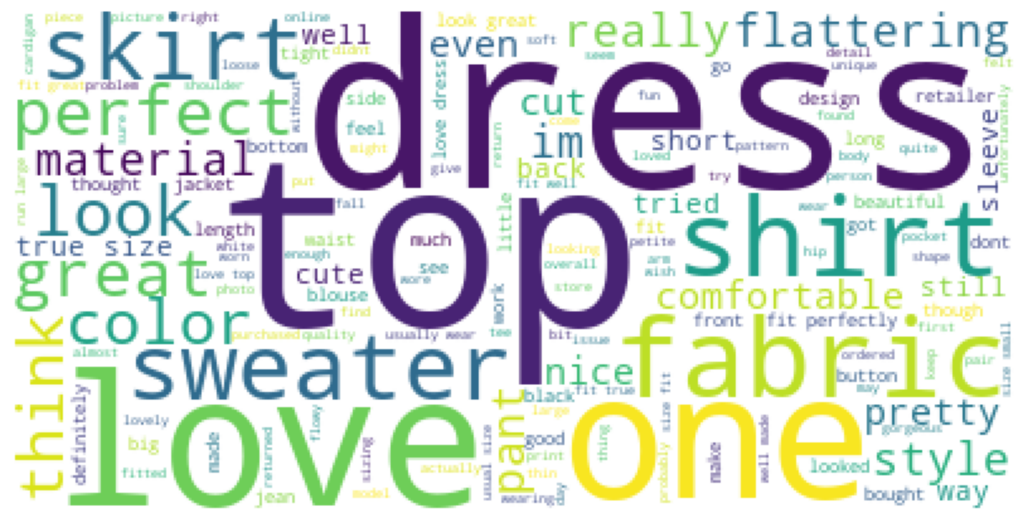

In [108]:
from wordcloud import WordCloud 

wordcloud = WordCloud(background_color="white", max_words =250).generate(all_words)

plt.figure(figsize = (13, 13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

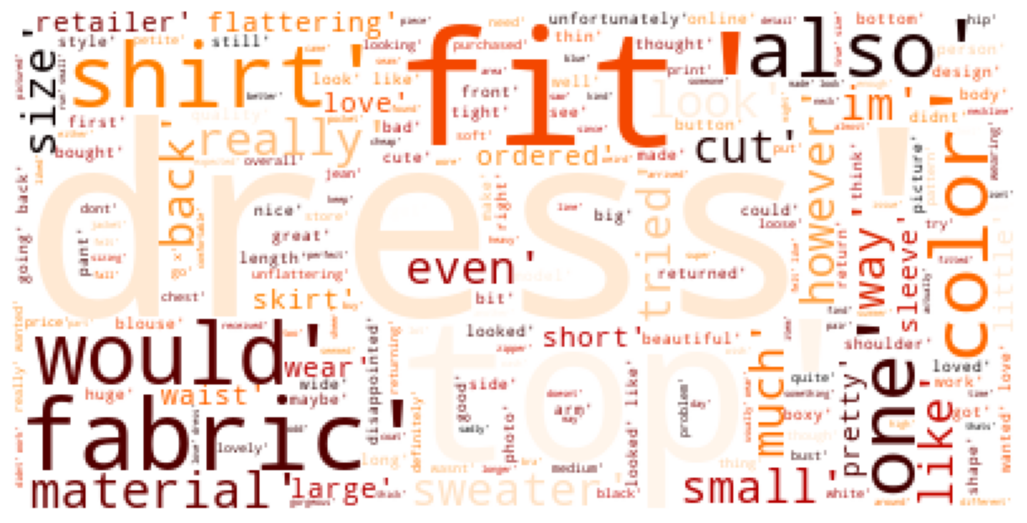

In [109]:
wordcloud = WordCloud(background_color="white", max_words =250, colormap='gist_heat').generate(str(neg_words))

plt.figure(figsize = (13, 13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

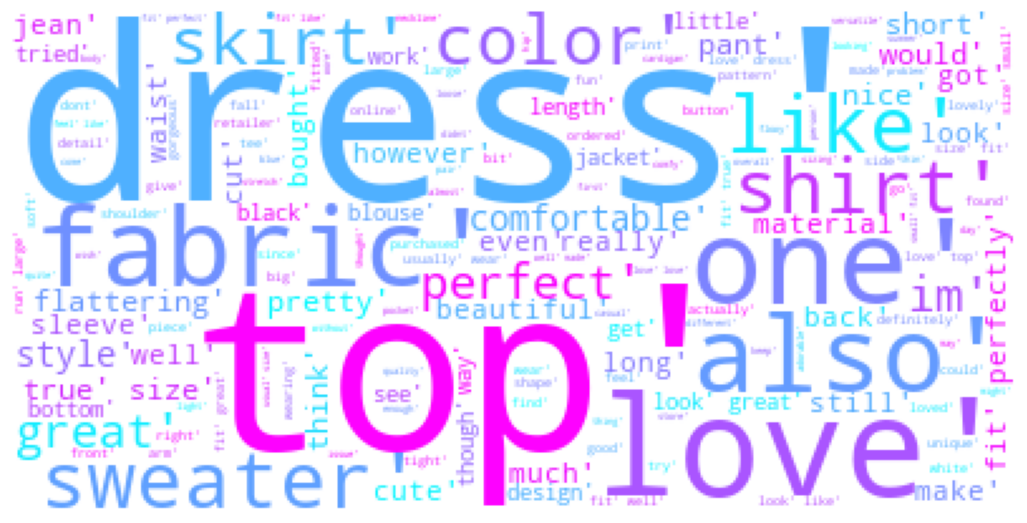

In [110]:
wordcloud = WordCloud(background_color="white", max_words =250, colormap='cool').generate(str(pos_words))

plt.figure(figsize = (13, 13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 8) SENTIMENT CLASSIFICATION WITH MACHINE LEARNING & DEEP LEARNING 

Before moving on to modeling, as data preprocessing steps WE will need to perform vectorization and train-test split. But you will perform the vectorization for the first time.

Machine learning algorithms most often take numeric feature vectors as input. Thus, when working with text documents, we need a way to convert each document into a numeric vector. This process is known as text vectorization. Commonly used vectorization approach that we will use here is to represent each text as a vector of word counts.

At this moment, we have our review text column as a token (which has no punctuations and stopwords). We can use Scikit-learn’s CountVectorizer to convert the text collection into a matrix of token counts. We can imagine this resulting matrix as a 2-D matrix, where each row is a unique word, and each column is a review.

For Deep learning model, we will implement embedding layer for all words.

After performing data preprocessing, we will build your models using following classification algorithms:

Logistic Regression,

Naive Bayes,

Support Vector Machine,

Random Forest,

Ada Boosting

Deep Learning Model.

### 8.1 Train | Test & Split 

To run machine learning algorithms we need to convert text files into numerical feature vectors. We will use bag of words model for our analysis.

Let's first we split the data into train and test sets:

In [111]:
df.head()

review_text  \
0                                                                                                                                                              absolutely wonderful silky sexy comfortable   
1                     love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi someone truly petite   
2  high hope dress really wanted work initially ordered petite small usual size found small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight l...   
3                                                                                                                 love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment   
4                                                                                           shirt flattering due adjustable front tie perfect length wear legging sleeveless pair well cardigan love shirt   

   recommended_ind  
0                1  
1                1  
2                0  
3                1  
4                1

In [112]:
from sklearn.model_selection import train_test_split

In [113]:
X = df["review_text"]
y= df["recommended_ind"]

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

In the next step, we will create a numerical feature vector for each document:

## 8.2 Vectorization  

### 8.2.a Count Vectorization

In [115]:
from sklearn.feature_extraction.text import CountVectorizer

In [116]:
vectorizer = CountVectorizer()

X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

In [117]:
type(X_train_count)

scipy.sparse.csr.csr_matrix

In [118]:
X_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [119]:
vectorizer.get_feature_names()

['aa',
 'ab',
 'abby',
 'abdomen',
 'ability',
 'able',
 'abo',
 'abovetheknee',
 'absolute',
 'absolutely',
 'absolutley',
 'abstract',
 'absurd',
 'abt',
 'abundance',
 'ac',
 'accent',
 'accented',
 'accentuate',
 'accentuated',
 'accentuates',
 'accentuating',
 'accept',
 'acceptable',
 'access',
 'accessorize',
 'accessorized',
 'accessorizing',
 'accessory',
 'accident',
 'accidental',
 'accidentally',
 'accommodate',
 'accommodates',
 'accommodating',
 'accomodate',
 'according',
 'accordingly',
 'account',
 'accurate',
 'accurately',
 'achieve',
 'across',
 'acrylic',
 'act',
 'action',
 'active',
 'activewear',
 'activity',
 'actual',
 'actuality',
 'actually',
 'ad',
 'ada',
 'add',
 'added',
 'addicted',
 'adding',
 'addition',
 'additional',
 'additionally',
 'address',
 'adequate',
 'adequately',
 'adjust',
 'adjustable',
 'adjusted',
 'adjusting',
 'adjustment',
 'admire',
 'admired',
 'admiring',
 'admit',
 'admittedly',
 'adn',
 'ador',
 'adorable',
 'adore',
 'adored',

In [120]:
pd.DataFrame(X_train_count.toarray(), columns = vectorizer.get_feature_names())

aa  ab  abby  abdomen  ability  able  abo  abovetheknee  absolute  \
0       0   0     0        0        0     0    0             0         0   
1       0   0     0        0        0     0    0             0         0   
2       0   0     0        0        0     0    0             0         0   
3       0   0     0        0        0     0    0             0         0   
4       0   0     0        0        0     0    0             0         0   
...    ..  ..   ...      ...      ...   ...  ...           ...       ...   
18107   0   0     0        0        0     0    0             0         0   
18108   0   0     0        0        0     0    0             0         0   
18109   0   0     0        0        0     0    0             0         0   
18110   0   0     0        0        0     0    0             0         0   
18111   0   0     0        0        0     0    0             0         0   

       absolutely  absolutley  abstract  absurd  abt  abundance  ac  accent  \
0               0           0         0       0    0          0   0       0   
1               0           0         0       0    0          0   0       0   
2               0           0         0       0    0          0   0       0   
3               0           0         0       0    0          0   0       0   
4               0           0         0       0    0          0   0       0   
...           ...         ...       ...     ...  ...        ...  ..     ...   
18107           0           0         0       0    0          0   0       0   
18108           0           0         0       0    0          0   0       0   
18109           0           0         0       0    0          0   0       0   
18110           0           0         0       0    0          0   0       0   
18111           0           0         0       0    0          0   0       0   

       accented  accentuate  accentuated  accentuates  accentuating  accept  \
0             0           0            0            0             0       0   
1             0           0            0            0             0       0   
2             0           0            0            0             0       0   
3             0           0            0            0             0       0   
4             0           0            0            0             0       0   
...         ...         ...          ...          ...           ...     ...   
18107         0           0            0            0             0       0   
18108         0           0            0            0             0       0   
18109         0           0            0            0             0       0   
18110         0           0            0            0             0       0   
18111         0           0            0            0             0       0   

       acceptable  access  accessorize  accessorized  accessorizing  \
0               0       0            0             0              0   
1               0       0            0             0              0   
2               0       0            0             0              0   
3               0       0            0             0              0   
4               0       0            0             0              0   
...           ...     ...          ...           ...            ...   
18107           0       0            0             0              0   
18108           0       0            0             0              0   
18109           0       0            0             0              0   
18110           0       0            0             0              0   
18111           0       0            0             0              0   

       accessory  accident  accidental  accidentally  accommodate  \
0              0         0           0             0            0   
1              0         0           0             0            0   
2              0         0           0             0            0   
3              0         0           0             0            0  

### 8.2.b TF-IDF Vectorization 

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [122]:
tf_idf_vectorizer = TfidfVectorizer()

X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [123]:
X_train_tf_idf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [124]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names())

aa   ab  abby  abdomen  ability  able  abo  abovetheknee  absolute  \
0     0.00 0.00  0.00     0.00     0.00  0.00 0.00          0.00      0.00   
1     0.00 0.00  0.00     0.00     0.00  0.00 0.00          0.00      0.00   
2     0.00 0.00  0.00     0.00     0.00  0.00 0.00          0.00      0.00   
3     0.00 0.00  0.00     0.00     0.00  0.00 0.00          0.00      0.00   
4     0.00 0.00  0.00     0.00     0.00  0.00 0.00          0.00      0.00   
...    ...  ...   ...      ...      ...   ...  ...           ...       ...   
18107 0.00 0.00  0.00     0.00     0.00  0.00 0.00          0.00      0.00   
18108 0.00 0.00  0.00     0.00     0.00  0.00 0.00          0.00      0.00   
18109 0.00 0.00  0.00     0.00     0.00  0.00 0.00          0.00      0.00   
18110 0.00 0.00  0.00     0.00     0.00  0.00 0.00          0.00      0.00   
18111 0.00 0.00  0.00     0.00     0.00  0.00 0.00          0.00      0.00   

       absolutely  absolutley  abstract  absurd  abt  abundance   ac  accent  \
0            0.00        0.00      0.00    0.00 0.00       0.00 0.00    0.00   
1            0.00        0.00      0.00    0.00 0.00       0.00 0.00    0.00   
2            0.00        0.00      0.00    0.00 0.00       0.00 0.00    0.00   
3            0.00        0.00      0.00    0.00 0.00       0.00 0.00    0.00   
4            0.00        0.00      0.00    0.00 0.00       0.00 0.00    0.00   
...           ...         ...       ...     ...  ...        ...  ...     ...   
18107        0.00        0.00      0.00    0.00 0.00       0.00 0.00    0.00   
18108        0.00        0.00      0.00    0.00 0.00       0.00 0.00    0.00   
18109        0.00        0.00      0.00    0.00 0.00       0.00 0.00    0.00   
18110        0.00        0.00      0.00    0.00 0.00       0.00 0.00    0.00   
18111        0.00        0.00      0.00    0.00 0.00       0.00 0.00    0.00   

       accented  accentuate  accentuated  accentuates  accentuating  accept  \
0          0.00        0.00         0.00         0.00          0.00    0.00   
1          0.00        0.00         0.00         0.00          0.00    0.00   
2          0.00        0.00         0.00         0.00          0.00    0.00   
3          0.00        0.00         0.00         0.00          0.00    0.00   
4          0.00        0.00         0.00         0.00          0.00    0.00   
...         ...         ...          ...          ...           ...     ...   
18107      0.00        0.00         0.00         0.00          0.00    0.00   
18108      0.00        0.00         0.00         0.00          0.00    0.00   
18109      0.00        0.00         0.00         0.00          0.00    0.00   
18110      0.00        0.00         0.00         0.00          0.00    0.00   
18111      0.00        0.00         0.00         0.00          0.00    0.00   

       acceptable  access  accessorize  accessorized  accessorizing  \
0            0.00    0.00         0.00          0.00           0.00   
1            0.00    0.00         0.00          0.00           0.00   
2            0.00    0.00         0.00          0.00           0.00   
3            0.00    0.00         0.00          0.00           0.00   
4            0.00    0.00         0.00          0.00           0.00   
...           ...     ...          ...           ...            ...   
18107        0.00    0.00         0.00          0.00           0.00   
18108        0.00    0.00         0.00          0.00           0.00   
18109        0.00    0.00         0.00          0.00           0.00   
18110        0.00    0.00         0.00          0.00           0.00   
18111        0.00    0.00         0.00          0.00           0.00   

       accessory  accident  accidental  accidentally  accommodate  \
0           0.00      0.00        0.00          0.00         0.00   
1           0.00      0.00        0.00          0.00         0.00   
2           0.00      0.00        0.00          0.00         0.00   
3           0.00      0.00      

Before diving into modelling, we will create a User-Defined-Function for comparing models at the end.

In [125]:
from sklearn.metrics import confusion_matrix,classification_report, f1_score, recall_score, accuracy_score, precision_score

In [126]:
def eval(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print("Test_Set")
    print(classification_report(y_test, y_pred))
    print("Train_Set")
    print(classification_report(y_train, y_pred_train))
    fig, ax = plt.subplots(figsize=(8, 8))
    
    plot_confusion_matrix(model, X_test, y_test, ax=ax)

Now it's time to train all models using TFIDF and Count vectorizer data.

## 9) MACHINE LEARNING MODELLING 

### 9.1 Logistic Regression

#### 9.1.a Logistic Regression With Count Vectorizor 

In [127]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(C =0.6, max_iter=1000, class_weight= "balanced", random_state=101)
log.fit(X_train_count,y_train)

LogisticRegression(C=0.6, class_weight='balanced', max_iter=1000,
                   random_state=101)

LOG MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.61      0.80      0.69       820
           1       0.95      0.89      0.92      3709

    accuracy                           0.87      4529
   macro avg       0.78      0.84      0.81      4529
weighted avg       0.89      0.87      0.88      4529

Train_Set
              precision    recall  f1-score   support

           0       0.72      0.96      0.82      3281
           1       0.99      0.92      0.95     14831

    accuracy                           0.92     18112
   macro avg       0.85      0.94      0.89     18112
weighted avg       0.94      0.92      0.93     18112



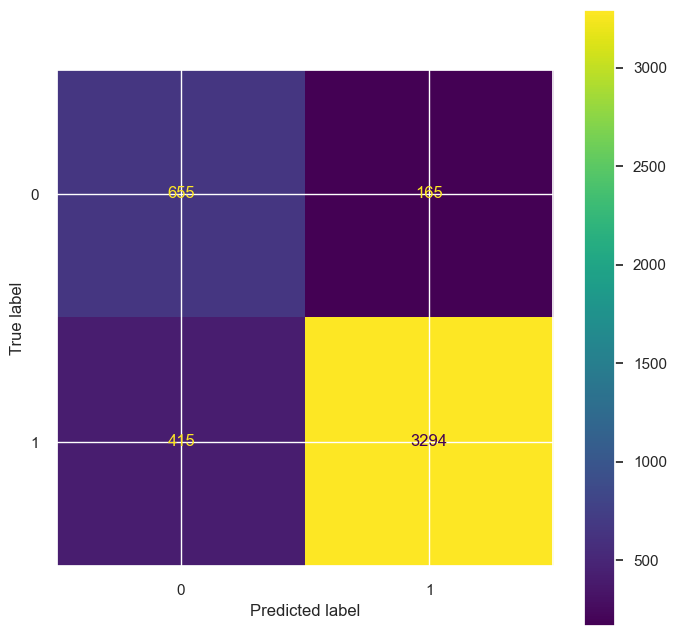

In [128]:
print("LOG MODEL")

eval(log, X_train_count, X_test_count)

In [129]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = LogisticRegression(C =0.6, max_iter=1000, class_weight= "balanced", random_state=101)
    scores = cross_val_score(model, X_train_count, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        log_count_rec = scores
    elif i == "f1-1":
        log_count_f1 = scores
    elif i == "accuracy":
        log_count_acc = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8663865231239555

 precision-0          score for count : 0.6004732142128997

 recall-0             score for count : 0.7860432574690488

 f1-0                 score for count : 0.6806600348422279

 precision-1          score for count : 0.9492144073093828

 recall-1             score for count : 0.8841613760989325

 f1-1                 score for count : 0.9155098938458213



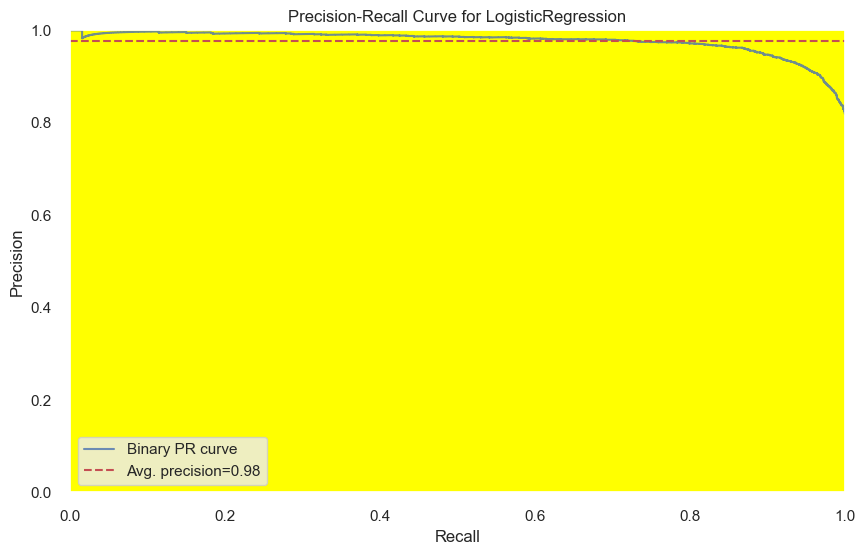

In [130]:
from yellowbrick.classifier import PrecisionRecallCurve
viz = PrecisionRecallCurve(
                            LogisticRegression(C =0.6, max_iter=1000, class_weight= "balanced", random_state=101),
                            classes=log.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('yellow')

viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [131]:
log_AP_count = viz.score_

#### 9.1.b Logistic Regression With TF-IDF Vectorizer

In [132]:
log = LogisticRegression(C=0.1, max_iter=1000, random_state=101, class_weight="balanced")

log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=101)

LOG MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.55      0.86      0.67       820
           1       0.97      0.85      0.90      3709

    accuracy                           0.85      4529
   macro avg       0.76      0.85      0.79      4529
weighted avg       0.89      0.85      0.86      4529

Train_Set
              precision    recall  f1-score   support

           0       0.57      0.89      0.69      3281
           1       0.97      0.85      0.91     14831

    accuracy                           0.86     18112
   macro avg       0.77      0.87      0.80     18112
weighted avg       0.90      0.86      0.87     18112



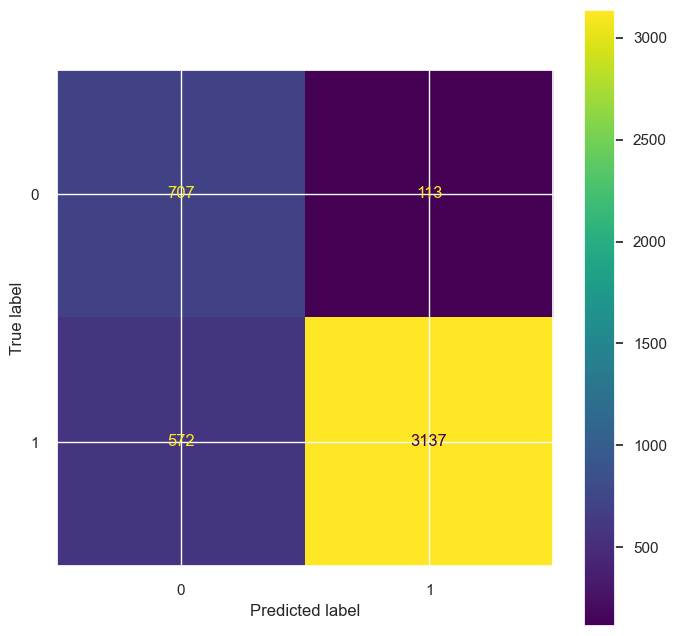

In [133]:
print("LOG MODEL")

eval(log, X_train_tf_idf, X_test_tf_idf)

In [134]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    LogisticRegression(C=0.1, max_iter=1000, random_state=101, class_weight="balanced")
    scores = cross_val_score(model, X_train_tf_idf, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        log_tfidf_rec = scores
    elif i == "f1-1":
        log_tfidf_f1 = scores
    elif i == "accuracy":
        log_tfidf_acc = scores
    print(f" {i:20} score for tfidf : {scores}\n")

 accuracy             score for tfidf : 0.860257465110808

 precision-0          score for tfidf : 0.5784925099903739

 recall-0             score for tfidf : 0.8463887241456002

 f1-0                 score for tfidf : 0.6870476202382443

 precision-1          score for tfidf : 0.9621600784762144

 recall-1             score for tfidf : 0.8633260510402712

 f1-1                 score for tfidf : 0.9100295215782153



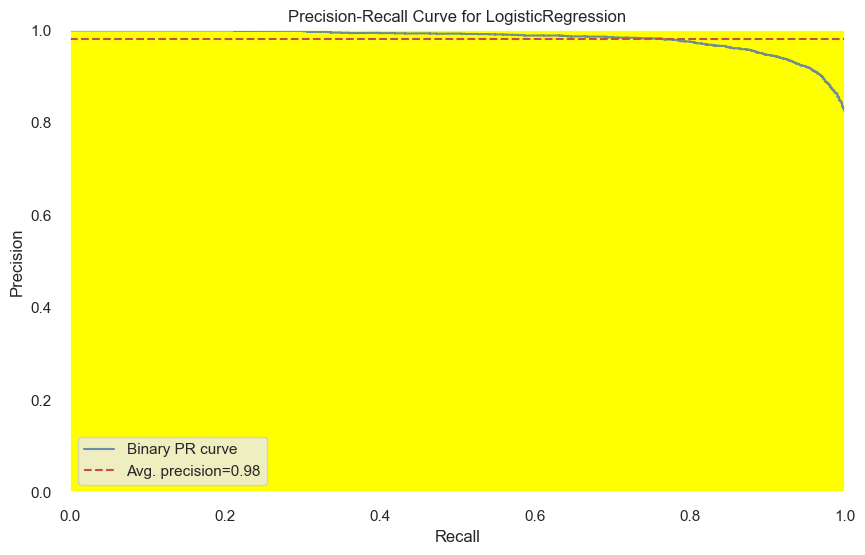

In [135]:
viz = PrecisionRecallCurve(
                            LogisticRegression(C=0.1, max_iter=1000, random_state=101, class_weight="balanced"),
                            classes=log.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('yellow')

viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [136]:
log_AP_tfidf = viz.score_

### 9.2 Naive Bayes

#### 9.2.a Naive Bayes With Count Vectorizor

In [137]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB # BernoulliNB for binary model

In [138]:
nb = MultinomialNB()
nb.fit(X_train_count, y_train)

MultinomialNB()

NB MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.67      0.74      0.70       820
           1       0.94      0.92      0.93      3709

    accuracy                           0.89      4529
   macro avg       0.80      0.83      0.82      4529
weighted avg       0.89      0.89      0.89      4529

Train_Set
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      3281
           1       0.96      0.92      0.94     14831

    accuracy                           0.90     18112
   macro avg       0.83      0.87      0.85     18112
weighted avg       0.91      0.90      0.91     18112



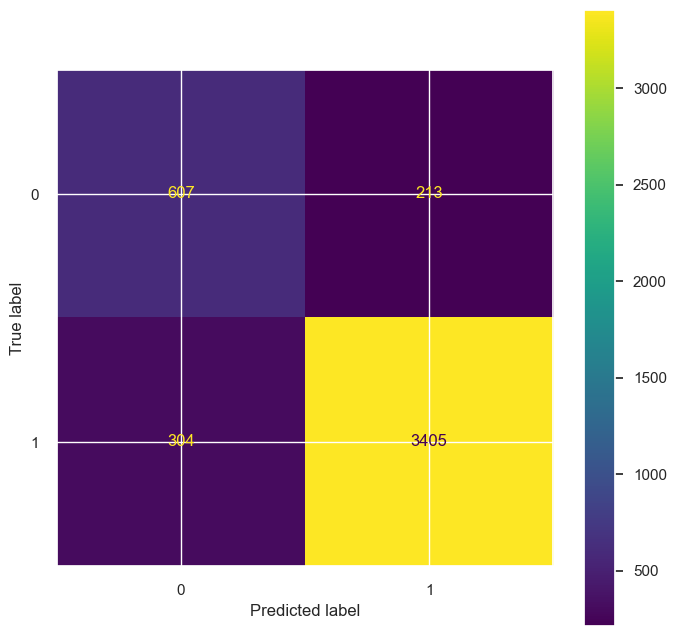

In [139]:
print("NB MODEL")

eval(nb, X_train_count, X_test_count)

In [140]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = MultinomialNB()
    scores = cross_val_score(model, X_train_count, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        nb_count_rec = scores
    elif i == "f1-1":
        nb_count_f1 = scores
    elif i == "accuracy":
        nb_count_acc = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8826189413968841

 precision-0          score for count : 0.654342059232186

 recall-0             score for count : 0.7476425235376973

 f1-0                 score for count : 0.6975979898377522

 precision-1          score for count : 0.9423871525871338

 recall-1             score for count : 0.9124805295596273

 f1-1                 score for count : 0.927165611564892



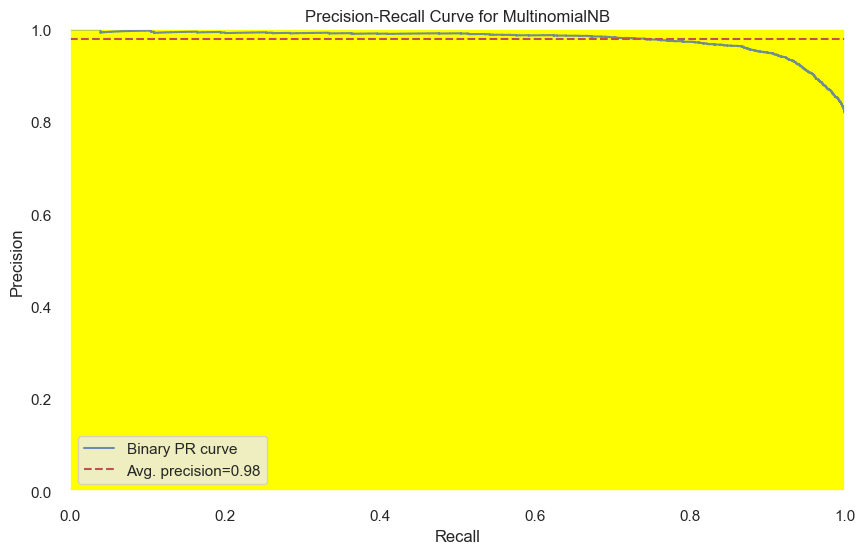

In [141]:
viz = PrecisionRecallCurve(
                            MultinomialNB(),
                            classes=nb.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('yellow')

viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [142]:
nb_AP_count = viz.score_

#### 9.2.b Naive Bayes With TF-IDF Vectorizer 

In [143]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
nb = MultinomialNB()
nb.fit(X_train_tf_idf, y_train)

MultinomialNB()

NB MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.87      0.17      0.28       820
           1       0.84      0.99      0.91      3709

    accuracy                           0.84      4529
   macro avg       0.85      0.58      0.60      4529
weighted avg       0.85      0.84      0.80      4529

Train_Set
              precision    recall  f1-score   support

           0       0.95      0.22      0.36      3281
           1       0.85      1.00      0.92     14831

    accuracy                           0.86     18112
   macro avg       0.90      0.61      0.64     18112
weighted avg       0.87      0.86      0.82     18112



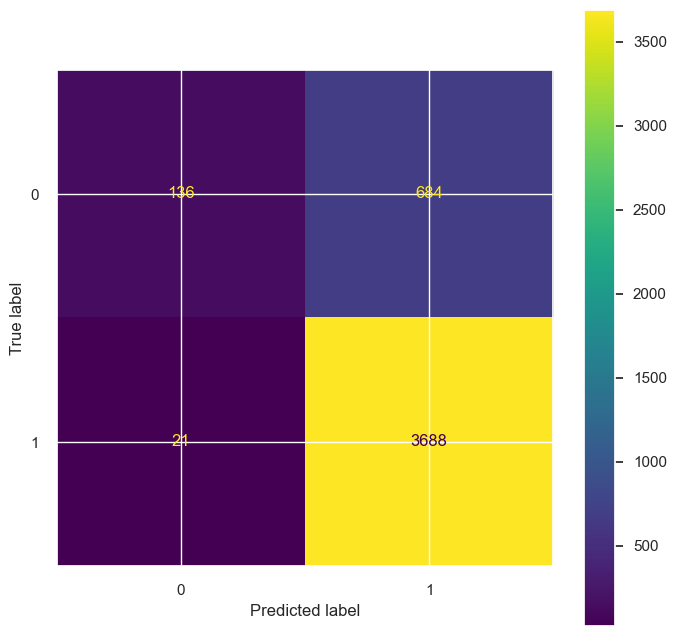

In [144]:
print("NB MODEL")
eval(nb, X_train_tf_idf, X_test_tf_idf)

In [145]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = BernoulliNB()
    scores = cross_val_score(model, X_train_tf_idf, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        nb_tfidf_rec = scores
    elif i == "f1-1":
        nb_tfidf_f1 = scores
    elif i == "accuracy":
        nb_tfidf_acc = scores
    print(f" {i:20} score for tfidf : {scores}\n")

 accuracy             score for tfidf : 0.8766563300312171

 precision-0          score for tfidf : 0.6434549409966672

 recall-0             score for tfidf : 0.7168618874638594

 f1-0                 score for tfidf : 0.6778544585841554

 precision-1          score for tfidf : 0.9357830256315294

 recall-1             score for tfidf : 0.9120087405692183

 f1-1                 score for tfidf : 0.9237148436630017



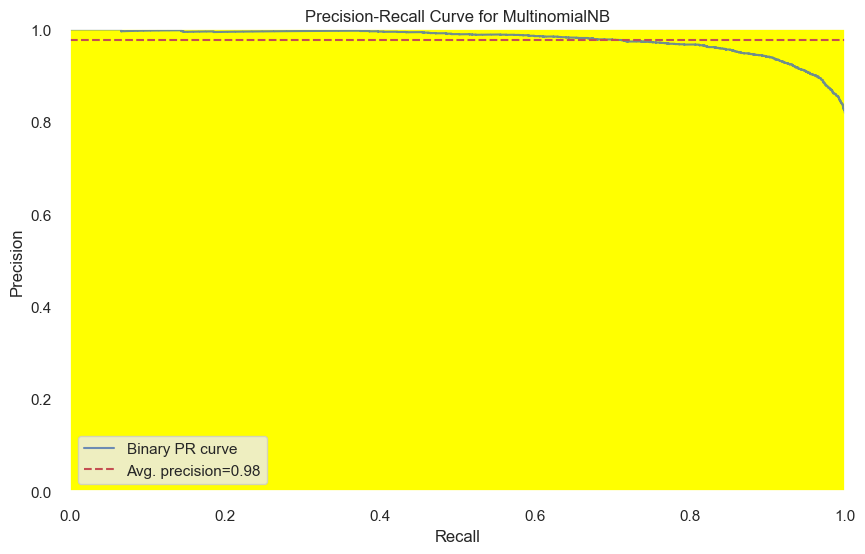

In [146]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(
                            MultinomialNB(),
                            classes=nb.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('yellow')

viz.fit(X_train_tf_idf, y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [147]:
nb_AP_tfidf = viz.score_

## 9.3 Support Vector Machine (SVM)

### 9.3.a Support Vector Machine (SVM) With Count Vectorizor 

In [148]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=0.01, class_weight="balanced", random_state=101)
svc.fit(X_train_count,y_train)

LinearSVC(C=0.01, class_weight='balanced', random_state=101)

SVC MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.60      0.84      0.70       820
           1       0.96      0.87      0.92      3709

    accuracy                           0.87      4529
   macro avg       0.78      0.86      0.81      4529
weighted avg       0.90      0.87      0.88      4529

Train_Set
              precision    recall  f1-score   support

           0       0.65      0.92      0.76      3281
           1       0.98      0.89      0.93     14831

    accuracy                           0.90     18112
   macro avg       0.82      0.91      0.85     18112
weighted avg       0.92      0.90      0.90     18112



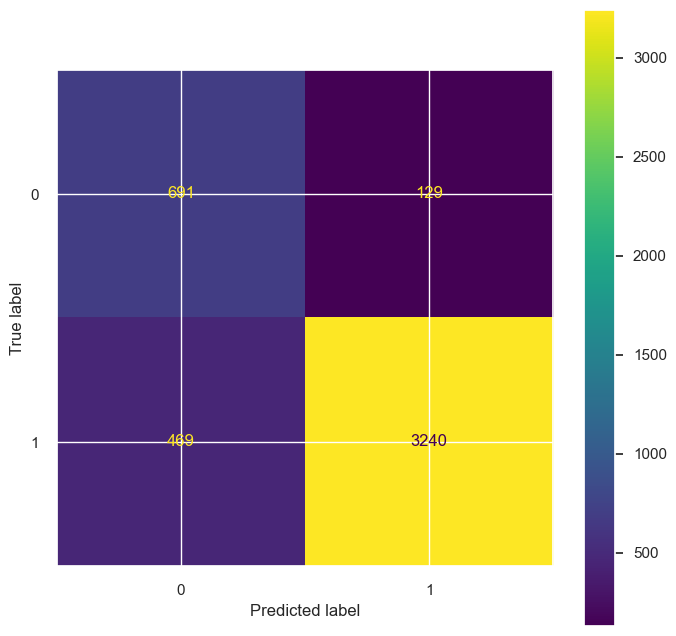

In [149]:
print("SVC MODEL")

eval(svc, X_train_count, X_test_count)

In [150]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = LinearSVC(C=0.01, class_weight="balanced", random_state=101)
    scores = cross_val_score(model, X_train_count, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        svc_count_rec = scores
    elif i == "f1-1":
        svc_count_f1 = scores
    elif i == "accuracy":
        svc_count_acc = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8649509741181862

 precision-0          score for count : 0.590799663472119

 recall-0             score for count : 0.8305396990140114

 f1-0                 score for count : 0.6902787096697695

 precision-1          score for count : 0.9588319718226306

 recall-1             score for count : 0.872563900304075

 f1-1                 score for count : 0.91363862996587



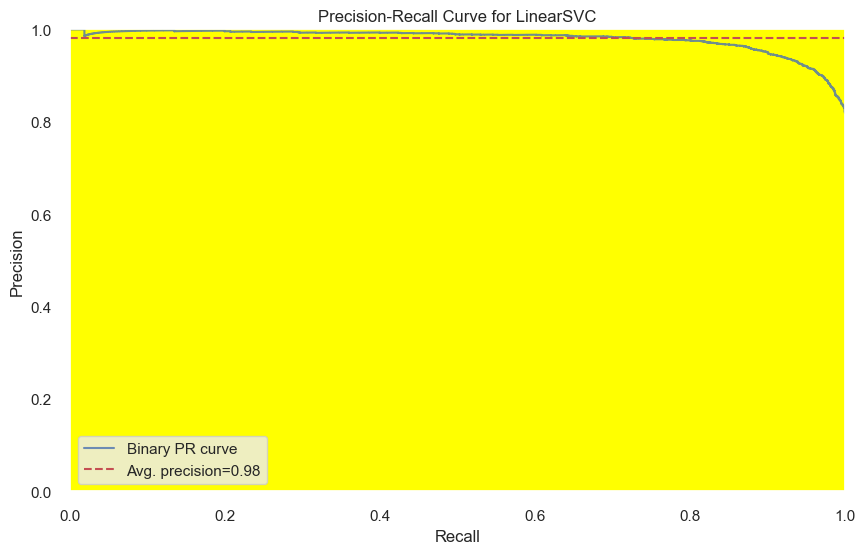

In [151]:
viz = PrecisionRecallCurve(
                            LinearSVC(C=0.01, class_weight="balanced", random_state=101),
                            classes=svc.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('yellow')

viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [152]:
svc_AP_count = viz.score_

### 9.3.b Support Vector Machine (SVM) With TF-IDF Vectorizer 

In [153]:
svc = LinearSVC(C=0.01, class_weight="balanced", random_state=101)

svc.fit(X_train_tf_idf, y_train)

LinearSVC(C=0.01, class_weight='balanced', random_state=101)

SVC MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.55      0.87      0.67       820
           1       0.97      0.84      0.90      3709

    accuracy                           0.85      4529
   macro avg       0.76      0.86      0.79      4529
weighted avg       0.89      0.85      0.86      4529

Train_Set
              precision    recall  f1-score   support

           0       0.57      0.89      0.69      3281
           1       0.97      0.85      0.91     14831

    accuracy                           0.86     18112
   macro avg       0.77      0.87      0.80     18112
weighted avg       0.90      0.86      0.87     18112



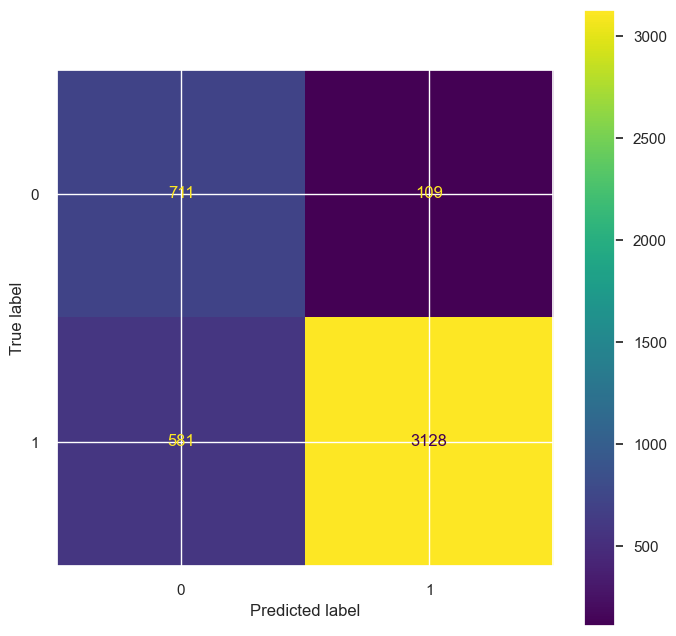

In [154]:
print("SVC MODEL")

eval(svc, X_train_tf_idf, X_test_tf_idf)

In [155]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = LinearSVC(C=0.01, class_weight="balanced", random_state=101)
    scores = cross_val_score(model, X_train_tf_idf, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        svc_tfidf_rec = scores
    elif i == "f1-1":
        svc_tfidf_f1 = scores
    elif i == "accuracy":
        svc_tfidf_acc = scores
    print(f" {i:20} score for tfidf : {scores}\n")

 accuracy             score for tfidf : 0.8430870703074053

 precision-0          score for tfidf : 0.5428195619628373

 recall-0             score for tfidf : 0.8576673585884796

 f1-0                 score for tfidf : 0.6646097767647368

 precision-1          score for tfidf : 0.9639062389709894

 recall-1             score for tfidf : 0.8398624664435934

 f1-1                 score for tfidf : 0.8975617321619218



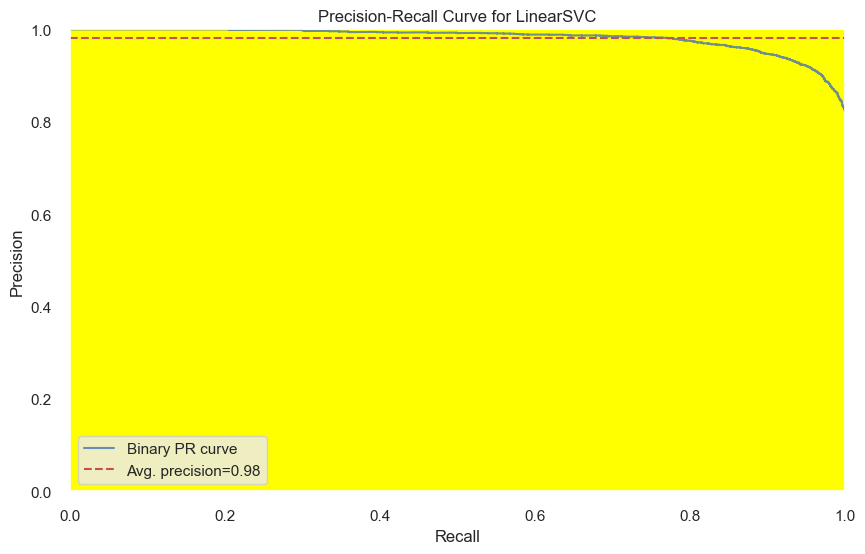

<AxesSubplot:title={'center':'Precision-Recall Curve for LinearSVC'}, xlabel='Recall', ylabel='Precision'>

In [156]:
viz = PrecisionRecallCurve(
                            LinearSVC(C=0.01, class_weight="balanced", random_state=101),
                            classes=svc.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('yellow')

viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show()

In [157]:
svc_AP_tfidf = viz.score_

## 9.4 Random Forest 

### 9.4.a Random Forest With Count Vectorizer 

In [158]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(200, max_depth = 12, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_count, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=200,
                       n_jobs=-1, random_state=42)

RF MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.57      0.78      0.66       820
           1       0.95      0.87      0.91      3709

    accuracy                           0.85      4529
   macro avg       0.76      0.83      0.78      4529
weighted avg       0.88      0.85      0.86      4529

Train_Set
              precision    recall  f1-score   support

           0       0.63      0.90      0.74      3281
           1       0.97      0.88      0.93     14831

    accuracy                           0.89     18112
   macro avg       0.80      0.89      0.83     18112
weighted avg       0.91      0.89      0.89     18112



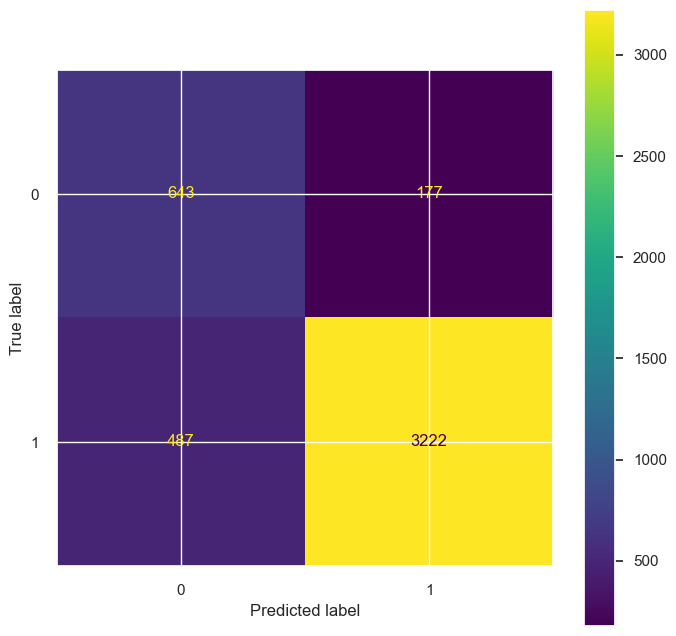

In [159]:
print("RF MODEL")

eval(rf, X_train_count, X_test_count)

In [160]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = RandomForestClassifier(200, max_depth = 12, random_state = 42, n_jobs = -1, class_weight="balanced")
    scores = cross_val_score(model, X_train_count, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        rf_count_rec = scores
    elif i == "f1-1":
        rf_count_f1 = scores
    elif i == "accuracy":
        rf_count_acc= scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8500434248393738

 precision-0          score for count : 0.5623773261675364

 recall-0             score for count : 0.7866502335236119

 f1-0                 score for count : 0.6554505796690441

 precision-1          score for count : 0.9482590583977227

 recall-1             score for count : 0.8640680633886655

 f1-1                 score for count : 0.9041336198854516



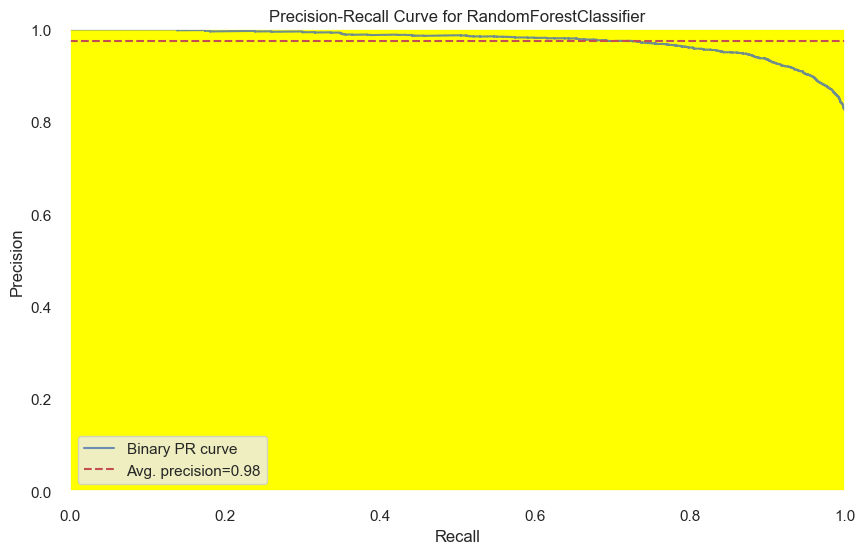

In [161]:
viz = PrecisionRecallCurve(
                            RandomForestClassifier(200, max_depth = 12, random_state = 42, n_jobs = -1, class_weight="balanced"),
                            classes=rf.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('yellow')

viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [162]:
rf_AP_count = viz.score_

### 9.4.b Random Forest With TF-IDF Vectorizer 

In [163]:
rf = RandomForestClassifier(200, max_depth = 10, random_state = 42, n_jobs = -1, class_weight="balanced")

rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

RF MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.53      0.79      0.63       820
           1       0.95      0.84      0.89      3709

    accuracy                           0.83      4529
   macro avg       0.74      0.82      0.76      4529
weighted avg       0.87      0.83      0.85      4529

Train_Set
              precision    recall  f1-score   support

           0       0.59      0.90      0.72      3281
           1       0.97      0.86      0.92     14831

    accuracy                           0.87     18112
   macro avg       0.78      0.88      0.82     18112
weighted avg       0.91      0.87      0.88     18112



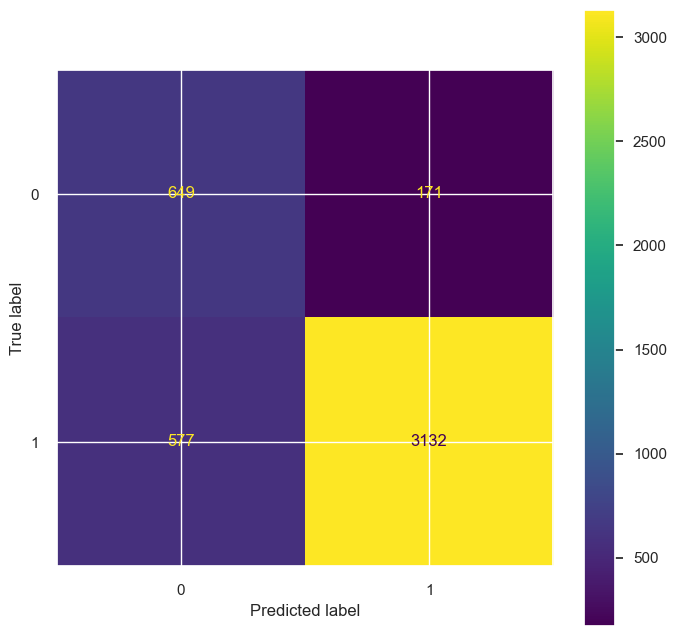

In [164]:
print("RF MODEL")

eval(rf, X_train_tf_idf, X_test_tf_idf)

In [165]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = RandomForestClassifier(200, max_depth = 10, random_state = 42, n_jobs = -1, class_weight="balanced")
    scores = cross_val_score(model, X_train_tf_idf, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        rf_tfidf_rec = scores
    elif i == "f1-1":
        rf_tfidf_f1 = scores
    elif i == "accuracy":
        rf_tfidf_acc = scores
    print(f" {i:20} score for tfidf : {scores}\n")

 accuracy             score for tfidf : 0.8367925712746362

 precision-0          score for tfidf : 0.5341097054259878

 recall-0             score for tfidf : 0.7936587219215656

 f1-0                 score for tfidf : 0.6381509884794976

 precision-1          score for tfidf : 0.9488705156666931

 recall-1             score for tfidf : 0.8463346498410559

 f1-1                 score for tfidf : 0.894598159264865



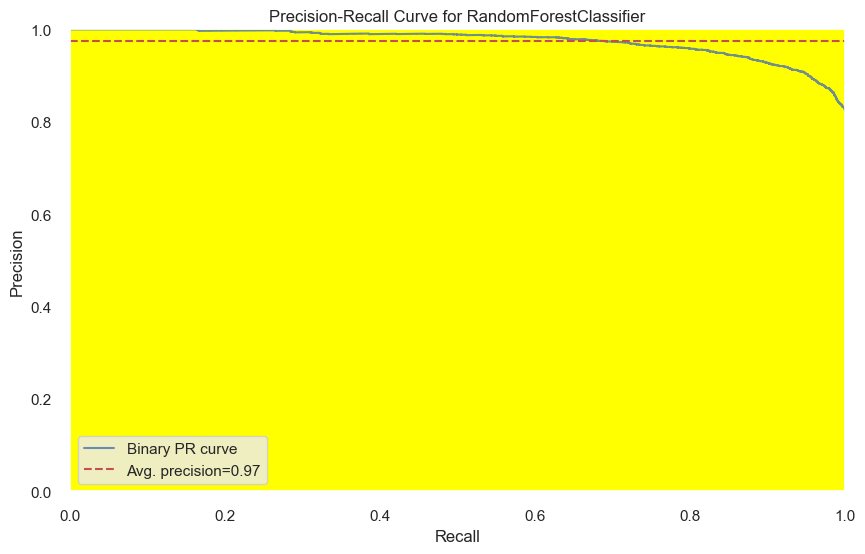

In [166]:
viz = PrecisionRecallCurve(
                            RandomForestClassifier(200, max_depth = 10, random_state = 42, n_jobs = -1, class_weight="balanced"),
                            classes=rf.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('yellow')

viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show()

In [167]:
rf_AP_tfidf = viz.score_

## 9.5 Ada Boosting 

### 9.5.a Ada Boosting With TF-IDF Vectorizer 

In [168]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_count, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

Ada MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.73      0.59      0.65       820
           1       0.91      0.95      0.93      3709

    accuracy                           0.89      4529
   macro avg       0.82      0.77      0.79      4529
weighted avg       0.88      0.89      0.88      4529

Train_Set
              precision    recall  f1-score   support

           0       0.80      0.66      0.72      3281
           1       0.93      0.96      0.94     14831

    accuracy                           0.91     18112
   macro avg       0.86      0.81      0.83     18112
weighted avg       0.90      0.91      0.90     18112



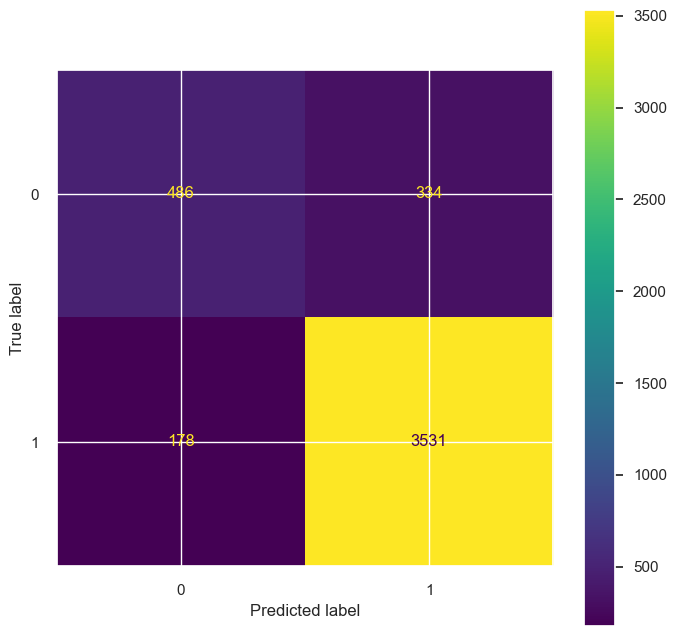

In [169]:
print("Ada MODEL")

eval(ada, X_train_count, X_test_count)

In [170]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
    scores = cross_val_score(model, X_train_count, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        ada_count_rec = scores
    elif i == "f1-1":
        ada_count_f1 = scores
    elif i == "accuracy":
        ada_count_acc = scores
    print(f" {i:20} score for count : {scores}\n")

 accuracy             score for count : 0.8785885068315652

 precision-0          score for count : 0.7047434954777423

 recall-0             score for count : 0.568720809548521

 f1-0                 score for count : 0.6289800986982089

 precision-1          score for count : 0.9085235154333284

 recall-1             score for count : 0.9471378225459066

 f1-1                 score for count : 0.9274076984635965



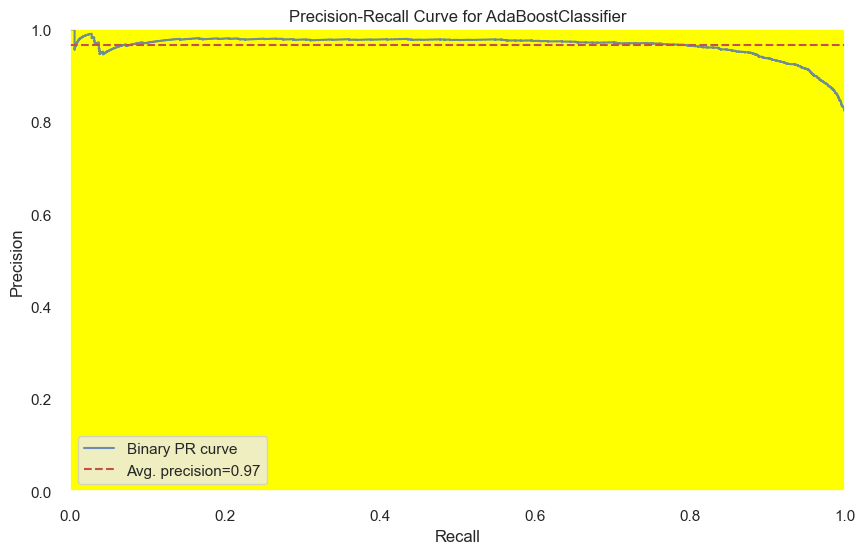

In [171]:
viz = PrecisionRecallCurve(
                            AdaBoostClassifier(n_estimators= 500, random_state = 42),
                            classes=ada.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('yellow')

viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [172]:
ada_AP_count = viz.score_

### 9.5.b Ada Boosting With TF-IDF Vectorizer 

In [173]:
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)

ada.fit(X_train_tf_idf, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

Ada MODEL
Test_Set
              precision    recall  f1-score   support

           0       0.71      0.58      0.63       820
           1       0.91      0.95      0.93      3709

    accuracy                           0.88      4529
   macro avg       0.81      0.76      0.78      4529
weighted avg       0.87      0.88      0.88      4529

Train_Set
              precision    recall  f1-score   support

           0       0.82      0.70      0.76      3281
           1       0.94      0.97      0.95     14831

    accuracy                           0.92     18112
   macro avg       0.88      0.83      0.85     18112
weighted avg       0.91      0.92      0.92     18112



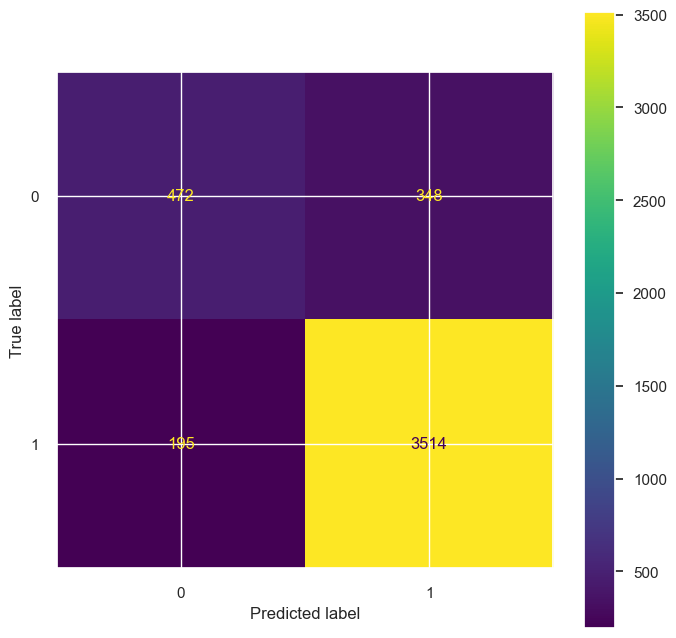

In [174]:
print("Ada MODEL")

eval(ada, X_train_tf_idf, X_test_tf_idf)

In [175]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision-0': make_scorer(precision_score, pos_label=0),
                 'recall-0': make_scorer(recall_score, pos_label=0),
                 'f1-0': make_scorer(f1_score, pos_label=0),
                 'precision-1': make_scorer(precision_score, pos_label=1),
                 'recall-1': make_scorer(recall_score, pos_label=1),
                 'f1-1': make_scorer(f1_score, pos_label=1)
                 }

for i, j in custom_scorer.items():
    model =AdaBoostClassifier(n_estimators= 500, random_state = 42)
    scores = cross_val_score(model, X_train_tf_idf, y_train, cv = 10, scoring = j).mean()
    if i == "recall-1":
        ada_tfidf_rec = scores
    elif i == "f1-1":
        ada_tfidf_f1 = scores
    elif i == "accuracy":
        ada_tfidf_acc = scores
    print(f" {i:20} score for tfidf : {scores}\n")

 accuracy             score for tfidf : 0.8718526895364725

 precision-0          score for tfidf : 0.6742919820168564

 recall-0             score for tfidf : 0.5675077841203944

 f1-0                 score for tfidf : 0.6160304236493095

 precision-1          score for tfidf : 0.9075588290492795

 recall-1             score for tfidf : 0.9391817507674579

 f1-1                 score for tfidf : 0.9230856147353173



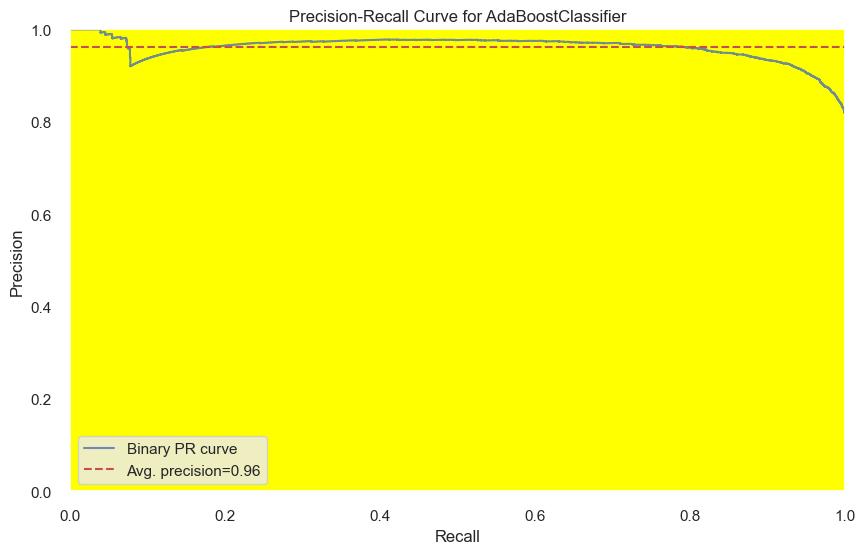

<AxesSubplot:title={'center':'Precision-Recall Curve for AdaBoostClassifier'}, xlabel='Recall', ylabel='Precision'>

In [176]:
viz = PrecisionRecallCurve(
                            AdaBoostClassifier(n_estimators= 500, random_state = 42),
                            classes=ada.classes_,
                            per_class=True,
                            cmap="Set1"
                           )

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('yellow')

viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show()

In [177]:
ada_AP_tfidf = viz.score_

## 10) DEEP LEARNING MODELLING

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df_dl = df_dl[["Review Text","Recommended IND"]]
df_dl.head()

Review Text  \
0                                                                                                                                                    Absolutely wonderful - silky and sexy and comfortable   
1  Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length...   
2  I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i co...   
3                                                                             I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!   
4         This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!   

   Recommended IND  
0                1  
1                1  
2                0  
3                1  
4                1

In [ ]:
df_dl.shape

(23486, 2)

In [ ]:
df_dl.dropna(inplace = True)

In [ ]:
df_dl.shape

(22641, 2)

### 10.1 Tokenization 

In [ ]:
X = df_dl['Review Text'].values
y = df_dl['Recommended IND'].values

In [ ]:
num_words = 10000 
# We have defined the most frequent 10000 repeated words in corpus for tokenizing. We ignore the rest.

tokenizer = Tokenizer(num_words=num_words) 
# The default values of "filters" are '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'. 
# If you also want to filters the numbers, then just "1234567890" at the end. 

In [ ]:
tokenizer.fit_on_texts(X)

### 10.2 Creating Word Index 

In [ ]:
tokenizer.word_index

{'the': 1,
 'i': 2,
 'and': 3,
 'a': 4,
 'it': 5,
 'is': 6,
 'this': 7,
 'to': 8,
 'in': 9,
 'but': 10,
 'on': 11,
 'for': 12,
 'of': 13,
 'with': 14,
 'was': 15,
 'so': 16,
 'my': 17,
 'dress': 18,
 'not': 19,
 'that': 20,
 'love': 21,
 'size': 22,
 'very': 23,
 'have': 24,
 'top': 25,
 'fit': 26,
 'are': 27,
 'like': 28,
 'be': 29,
 'as': 30,
 'me': 31,
 'wear': 32,
 "it's": 33,
 'great': 34,
 'too': 35,
 "i'm": 36,
 'or': 37,
 'am': 38,
 'just': 39,
 'you': 40,
 'would': 41,
 'they': 42,
 'up': 43,
 'at': 44,
 'fabric': 45,
 'small': 46,
 'color': 47,
 'look': 48,
 'if': 49,
 'more': 50,
 'really': 51,
 'ordered': 52,
 'little': 53,
 'perfect': 54,
 'will': 55,
 'one': 56,
 'these': 57,
 'flattering': 58,
 'well': 59,
 'an': 60,
 'soft': 61,
 'out': 62,
 'back': 63,
 'because': 64,
 'had': 65,
 'can': 66,
 '\r': 67,
 'comfortable': 68,
 'cute': 69,
 'nice': 70,
 'than': 71,
 'bought': 72,
 'beautiful': 73,
 'when': 74,
 'all': 75,
 'looks': 76,
 'bit': 77,
 'fits': 78,
 'large': 79,

In [ ]:
len(tokenizer.word_index) 

14847

### 10.3 Converting Tokens To Numeric 

In [ ]:
X_num_tokens = tokenizer.texts_to_sequences(X)

In [ ]:
num_tokens = [len(tokens) for tokens in X_num_tokens]
num_tokens = np.array(num_tokens)

In [ ]:
np.array(X_num_tokens)

array([list([253, 532, 917, 3, 662, 3, 68]),
       list([21, 7, 18, 33, 1713, 99, 2, 1322, 8, 221, 5, 9, 4, 106, 3, 36, 314, 2, 131, 1243, 2, 429, 41, 24, 52, 5, 136, 1243, 33, 95, 2, 72, 4, 95, 3, 38, 501, 2, 21, 1, 86, 11, 31, 416, 39, 4, 53, 454, 1, 392, 41, 155, 29, 4, 130, 1372, 11, 438, 439, 6, 772, 95]),
       list([2, 65, 312, 178, 1095, 12, 7, 18, 3, 51, 195, 5, 8, 102, 12, 31, 2, 1152, 52, 1, 95, 46, 17, 236, 22, 10, 2, 219, 7, 8, 29, 6689, 46, 16, 46, 9, 661, 20, 2, 118, 19, 784, 5, 43, 2, 2147, 5, 9, 95, 97, 82, 15, 39, 637, 250, 1, 25, 656, 15, 68, 3, 26, 258, 10, 1, 175, 656, 65, 4, 23, 148, 272, 475, 3, 527, 718, 489, 4601, 151, 975, 1876, 4, 1877, 142, 1589, 15, 1, 4601, 151, 475, 830, 3247, 313, 1, 469, 5, 688]),
       ...,
       list([7, 26, 59, 10, 1, 25, 15, 23, 121, 203, 7, 429, 41, 24, 561, 12, 31, 36, 314, 2, 15, 427, 8, 179, 5, 11, 9, 1, 106, 3, 124, 241, 5, 136, 14, 244, 45, 5, 41, 24, 166, 34]),
       list([2, 72, 7, 18, 12, 4, 592, 2, 24, 7, 138, 3, 33, 

In [ ]:
X[105]

'The shirt is exactly as it is pictured, i have the burnt orange color and love it! i received numerous compliments both paired with jeans and tucked into a fun skirt. it fits true to size, as i normally wear a small in all retailer however it is the slightest bit tight in the shoulders. i would give this top a 5/5.'

In [ ]:
print(X_num_tokens[105])

[1, 80, 6, 478, 30, 5, 6, 389, 2, 24, 1, 1905, 482, 47, 3, 21, 5, 2, 243, 2182, 210, 189, 563, 14, 92, 3, 871, 313, 4, 283, 109, 5, 78, 130, 8, 22, 30, 2, 239, 32, 4, 46, 9, 75, 103, 143, 5, 6, 1, 2868, 77, 148, 9, 1, 200, 2, 41, 324, 7, 25, 4, 265, 265]


In [ ]:
# tokenizer.word_index["The"]
# This code will give you an error since "The" which is not among the most repeated 10000 words was excluded while tokenizing

In [ ]:
tokenizer.word_index["shirt"]

80

In [ ]:
tokenizer.word_index["exactly"]

478

### 10.4 The Determination of Maximum Number of Tokens 

This part is the preparation for padding.

In [ ]:
num_tokens.mean()

60.39287133960514

In [ ]:
num_tokens.max() 

116

In [ ]:
num_tokens.argmax()

16263

In [ ]:
X[16263]

"I love maeve tops. i love the material and feel of this brand. when i saw the new tops that came out i ran to my local store to try one on. i'm usually a large in a top, once in a while an xl. they only had a large to try so i tried it in the black motif.\ni could barely get the top on. it looked like i was missing 1/2 of the top. i doubled checked the size and it was a large.\nit's a shame, the top is really cute. if you are the least bit broad or busty, go up a size or two. if you are usually a"

In [ ]:
len(X[16263])

499

In [ ]:
num_tokens.argmin()

820

In [ ]:
X[820]

'Great style!'

In [ ]:
len(X[820])

12

### 10.5 Fixing Token Counts of All documents (Pad Sequences) 

In [ ]:
len(X_num_tokens[105])

63

In [ ]:
np.array(X_num_tokens[105])

array([   1,   80,    6,  478,   30,    5,    6,  389,    2,   24,    1,
       1905,  482,   47,    3,   21,    5,    2,  243, 2182,  210,  189,
        563,   14,   92,    3,  871,  313,    4,  283,  109,    5,   78,
        130,    8,   22,   30,    2,  239,   32,    4,   46,    9,   75,
        103,  143,    5,    6,    1, 2868,   77,  148,    9,    1,  200,
          2,   41,  324,    7,   25,    4,  265,  265])

In [ ]:
len(X_num_tokens[106])

7

In [ ]:
np.array(X_num_tokens[106])

array([  54,   18,   12,  495, 2088, 2955,  452])

In [ ]:
num_tokens = [len(tokens) for tokens in X_num_tokens]

num_tokens = np.array(num_tokens)

In [ ]:
num_tokens

array([ 7, 62, 97, ..., 42, 85, 18])

In [ ]:
max_tokens = 103

In [ ]:
sum(num_tokens < max_tokens) / len(num_tokens)

0.9604699439070712

In [ ]:
sum(num_tokens < max_tokens) # the number of documents which have 103 or less tokens

21746

In [ ]:
len(num_tokens)  # total number of all documents in corpus which is constrained by num_words as 20000

22641

In [ ]:
X_pad = pad_sequences(X_num_tokens, maxlen=max_tokens)

In [ ]:
X_pad.shape

(22641, 103)

In [ ]:
X_pad[105]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    1,   80,    6,  478,
         30,    5,    6,  389,    2,   24,    1, 1905,  482,   47,    3,
         21,    5,    2,  243, 2182,  210,  189,  563,   14,   92,    3,
        871,  313,    4,  283,  109,    5,   78,  130,    8,   22,   30,
          2,  239,   32,    4,   46,    9,   75,  103,  143,    5,    6,
          1, 2868,   77,  148,    9,    1,  200,    2,   41,  324,    7,
         25,    4,  265,  265])

## 10.6 Train | Set & Split 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, stratify=y, random_state=101)  

# we have been using stratify to prevent imbalance.

## 10.7 Modeling 

## Gated Recurrent Unit

In [ ]:
model = Sequential()

In [ ]:
embedding_size = 100

In [ ]:
model.add(Embedding(input_dim=num_words,        
                    output_dim=embedding_size,                                       
                    input_length=max_tokens,    
                    name='embedding_layer')) 

In [ ]:
model.add(GRU(units=48, return_sequences=True))  
model.add(GRU(units=24, return_sequences=True)) 
model.add(GRU(units=12)) 
model.add(Dense(1, activation='sigmoid'))  

In [ ]:
optimizer = Adam(learning_rate=0.006)

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['Recall'])

In [ ]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 103, 100)          1000000   
_________________________________________________________________
gru (GRU)                    (None, 103, 48)           21600     
_________________________________________________________________
gru_1 (GRU)                  (None, 103, 24)           5328      
_________________________________________________________________
gru_2 (GRU)                  (None, 12)                1368      
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 1,028,309
Trainable params: 1,028,309
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", mode="auto", 
                           verbose=1, patience = 10, restore_best_weights=True)

In [ ]:
pd.Series(y_train).value_counts(normalize=True) 

1   0.82
0   0.18
dtype: float64

In [ ]:
weights = {0:82, 1:18}

In [ ]:
model.fit(X_train, y_train, epochs=30, batch_size=256, class_weight=weights,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/30
71/71 [==============================] - 41s 453ms/step - loss: 13.7697 - recall: 0.7588 - val_loss: 0.3458 - val_recall: 0.8665
Epoch 2/30
71/71 [==============================] - 29s 405ms/step - loss: 8.6308 - recall: 0.8627 - val_loss: 0.3994 - val_recall: 0.8137
Epoch 3/30
71/71 [==============================] - 28s 393ms/step - loss: 5.7830 - recall: 0.9080 - val_loss: 0.3568 - val_recall: 0.8501
Epoch 4/30
71/71 [==============================] - 29s 403ms/step - loss: 4.2982 - recall: 0.9345 - val_loss: 0.3351 - val_recall: 0.9067
Epoch 5/30
71/71 [==============================] - 28s 398ms/step - loss: 2.9961 - recall: 0.9542 - val_loss: 0.4124 - val_recall: 0.9021
Epoch 6/30
71/71 [==============================] - 29s 402ms/step - loss: 2.3955 - recall: 0.9639 - val_loss: 0.4324 - val_recall: 0.8806
Epoch 7/30
71/71 [==============================] - 28s 401ms/step - loss: 1.9415 - recall: 0.9727 - val_loss: 0.4675 - val_recall: 0.8779
Epoch 8/30
71/71 [========

In [ ]:
model.save('NLP_Sentiment_Analysis_Project')

INFO:tensorflow:Assets written to: NLP_Sentiment_Analysis_Project\assets


INFO:tensorflow:Assets written to: NLP_Sentiment_Analysis_Project\assets


## 10.8 Model Evaluation 

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

loss  recall  val_loss  val_recall
0 13.77    0.76      0.35        0.87
1  8.63    0.86      0.40        0.81
2  5.78    0.91      0.36        0.85
3  4.30    0.93      0.34        0.91
4  3.00    0.95      0.41        0.90

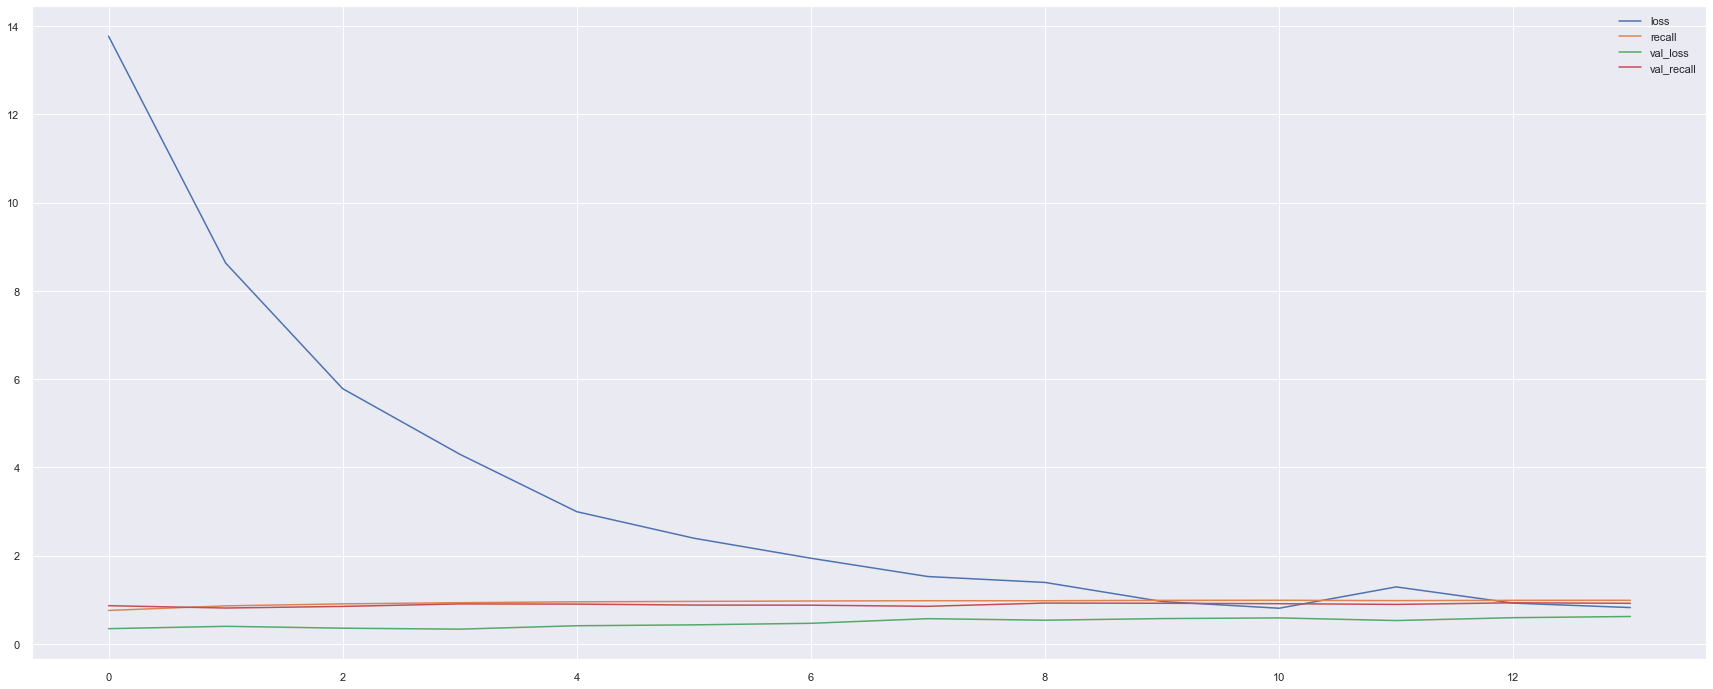

In [ ]:
model_loss.plot();

In [ ]:
model.evaluate(X_train, y_train)

566/566 [==============================] - 22s 35ms/step - loss: 0.1083 - recall: 0.9568


[0.10828769952058792, 0.9567797183990479]

In [ ]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 5s 33ms/step - loss: 0.3351 - recall: 0.9067


[0.33505985140800476, 0.9067134261131287]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

y_train_pred = (model.predict(X_train) >= 0.5).astype("int32")  

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

[[ 3252    29]
 [  641 14190]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3281
           1       1.00      0.96      0.98     14831

    accuracy                           0.96     18112
   macro avg       0.92      0.97      0.94     18112
weighted avg       0.97      0.96      0.96     18112



In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int32")

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))

[[ 599  221]
 [ 346 3363]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.73      0.68       820
           1       0.94      0.91      0.92      3709

    accuracy                           0.87      4529
   macro avg       0.79      0.82      0.80      4529
weighted avg       0.88      0.87      0.88      4529



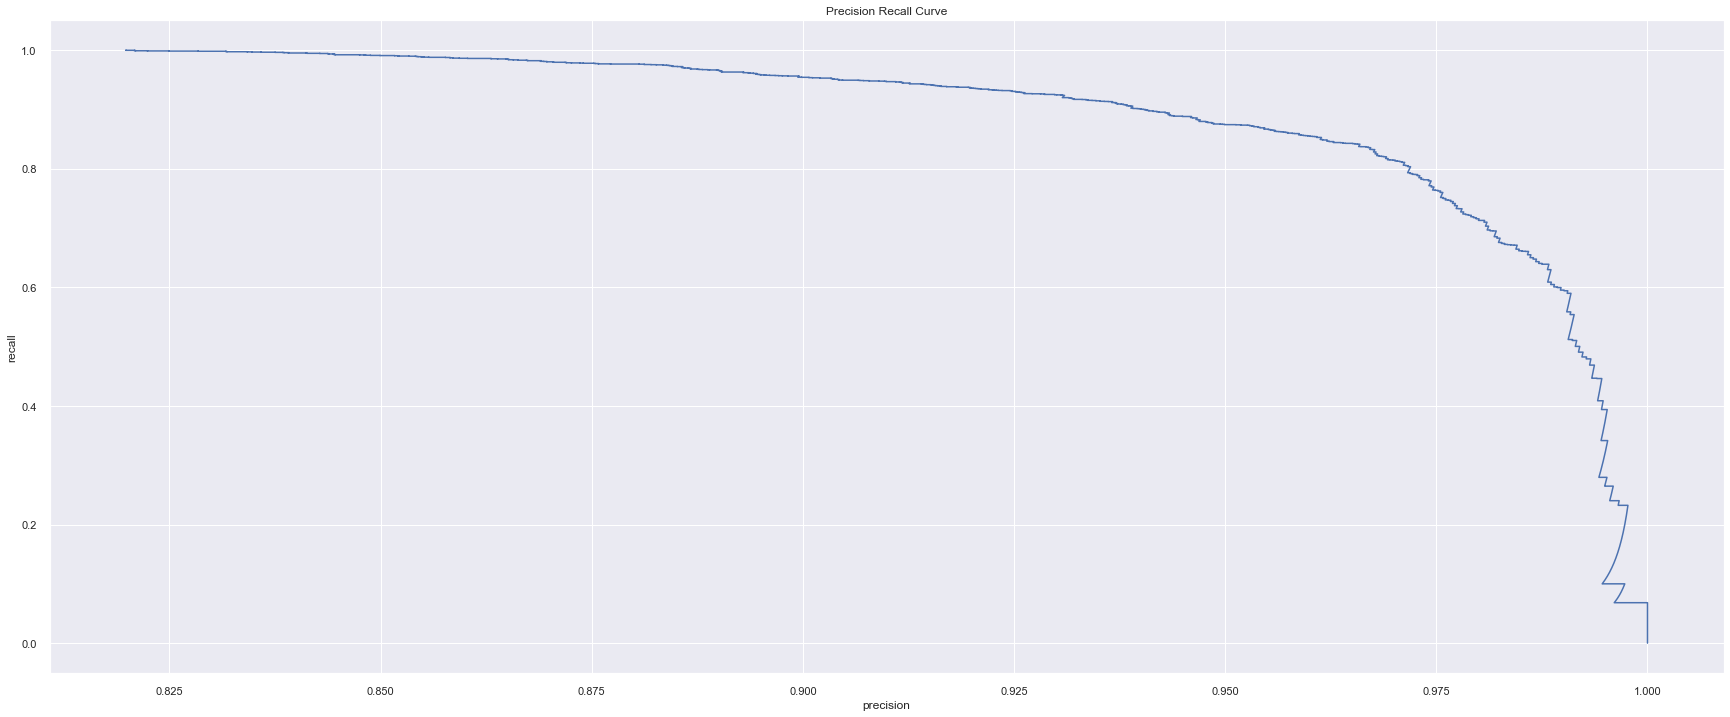

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_pred_proba = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# plt.plot([1, 0], [0, 1],'k--')
plt.plot(precision, recall)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Precision Recall Curve')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, recall_score,accuracy_score

DL_AP = average_precision_score(y_test, y_pred_proba)
DL_f1 = f1_score(y_test, y_pred)
DL_rec = recall_score(y_test, y_pred)
DL_acc = accuracy_score(y_test,y_pred)

## 11) PREDICTION 

In [ ]:
review1 = "Love this dress"
review2 = "Absolutely wonderful. silky and sexy and comfortable"
review3 = "i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up!"
review4 = "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!"
review5 = 'This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!'
review6 = 'I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress.'
review7 = 'I love this dress. i usually get an xs but it runs a little snug in bust so i ordered up a size. very flattering and feminine with the usual retailer flair for style.'
review8 = 'Dress runs small esp where the zipper area runs. i ordered the sp which typically fits me and it was very tight! the material on the top looks and feels very cheap that even just pulling on it will cause it to rip the fabric. pretty disappointed as it was going to be my christmas dress this year! needless to say it will be going back.'
review9 =  "if you are at least average height or taller, this may look good on you."
review10 = "sadly will be returning, but i'm sure i will find something to exchange it for!"
review11 = "Cute little dress fits tts. it is a little high waisted. good length for my 5'9 height. i like the dress, i'm just not in love with it. i dont think it looks or feels cheap. it appears just as pictured."
review12 = 'Loved the material, but i didnt really look at how long the dress was before i purchased both a large and a medium. im 5\'5" and there was atleast 5" of material at my feet. the gaps in the front are much wider than they look. felt like the dress just fell flat. both were returned. im usually a large and the med fit better. 36d 30 in jeans'
review13 = "I have been waiting for this sweater coat to ship for weeks and i was so excited for it to arrive. this coat is not true to size and made me look short and squat."
review14 = 'Very comfortable, material is good, cut out on sleeves flattering'
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10, review11, review12, review13, review14]

Let's convert reviews above to numeric by tokenizing.

In [ ]:
tokens = tokenizer.texts_to_sequences(reviews) 

Let's pad the tokenized reviews.

In [ ]:
tokens_pad = pad_sequences(tokens, maxlen=max_tokens)
tokens_pad.shape

(14, 103)

Let's predict the sentiment of our reviews.

In [ ]:
mod_pred = model.predict(tokens_pad)

In [ ]:
mod_pred

array([[0.97036076],
       [0.99278295],
       [0.990345  ],
       [0.9961406 ],
       [0.99610806],
       [0.98454154],
       [0.9950073 ],
       [0.02895463],
       [0.2282838 ],
       [0.95743895],
       [0.9749249 ],
       [0.02798599],
       [0.04129475],
       [0.9855091 ]], dtype=float32)

Let's create DataFrame for visually a better understanding.

In [ ]:
df_pred = pd.DataFrame(mod_pred, index=reviews)
df_pred.rename(columns={0: 'Pred_Proba'}, inplace=True)

In [ ]:
df_pred["Predicted_Feedbaack"] = df_pred["Pred_Proba"].apply(lambda x: "Recommended" if x>=0.5 else "Not Recommended")

In [ ]:
df_pred

Pred_Proba  \
Love this dress                                                                                                                                                                                                 0.97   
Absolutely wonderful. silky and sexy and comfortable                                                                                                                                                            0.99   
i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up!                                                                    0.99   
I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!                                                                                    1.00   
This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!                1.00   
I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of ...        0.98   
I love this dress. i usually get an xs but it runs a little snug in bust so i ordered up a size. very flattering and feminine with the usual retailer flair for style.                                          1.00   
Dress runs small esp where the zipper area runs. i ordered the sp which typically fits me and it was very tight! the material on the top looks and feels very cheap that even just pulling on it will...        0.03   
if you are at least average height or taller, this may look good on you.                                                                                                                                        0.23   
sadly will be returning, but i'm sure i will find something to exchange it for!                                                                                                                                 0.96   
Cute little dress fits tts. it is a little high waisted. good length for my 5'9 height. i like the dress, i'm just not in love with it. i dont think it looks or feels cheap. it appears just as pict...        0.97   
Loved the material, but i didnt really look at how long the dress was before i purchased both a large and a medium. im 5'5" and there was atleast 5" of material at my feet. the gaps in the front ar...        0.03   
I have been waiting for this sweater coat to ship for weeks and i was so excited for it to arrive. this coat is not true to size and made me look short and squat.                                              0.04   
Very comfortable, material is good, cut out on sleeves flattering                                                                                                                                               0.99   

                                                                                                                                                                                                         Predicted_Feedbaack  
Love this dress                                                                                                                                                                                                  Recommended  
Absolutely wonderful. silky and sexy and comfortable                                                                                                                                                             Recommended  
i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up!                                                                     Recommended  
I love, love, love this jumpsuit. it's fun, flirty, and fabulous! eve

## 12) COMPARING THE MODELS

Let's visually compare the models' F1 Scores, Recall Scores and Average Precision Score.

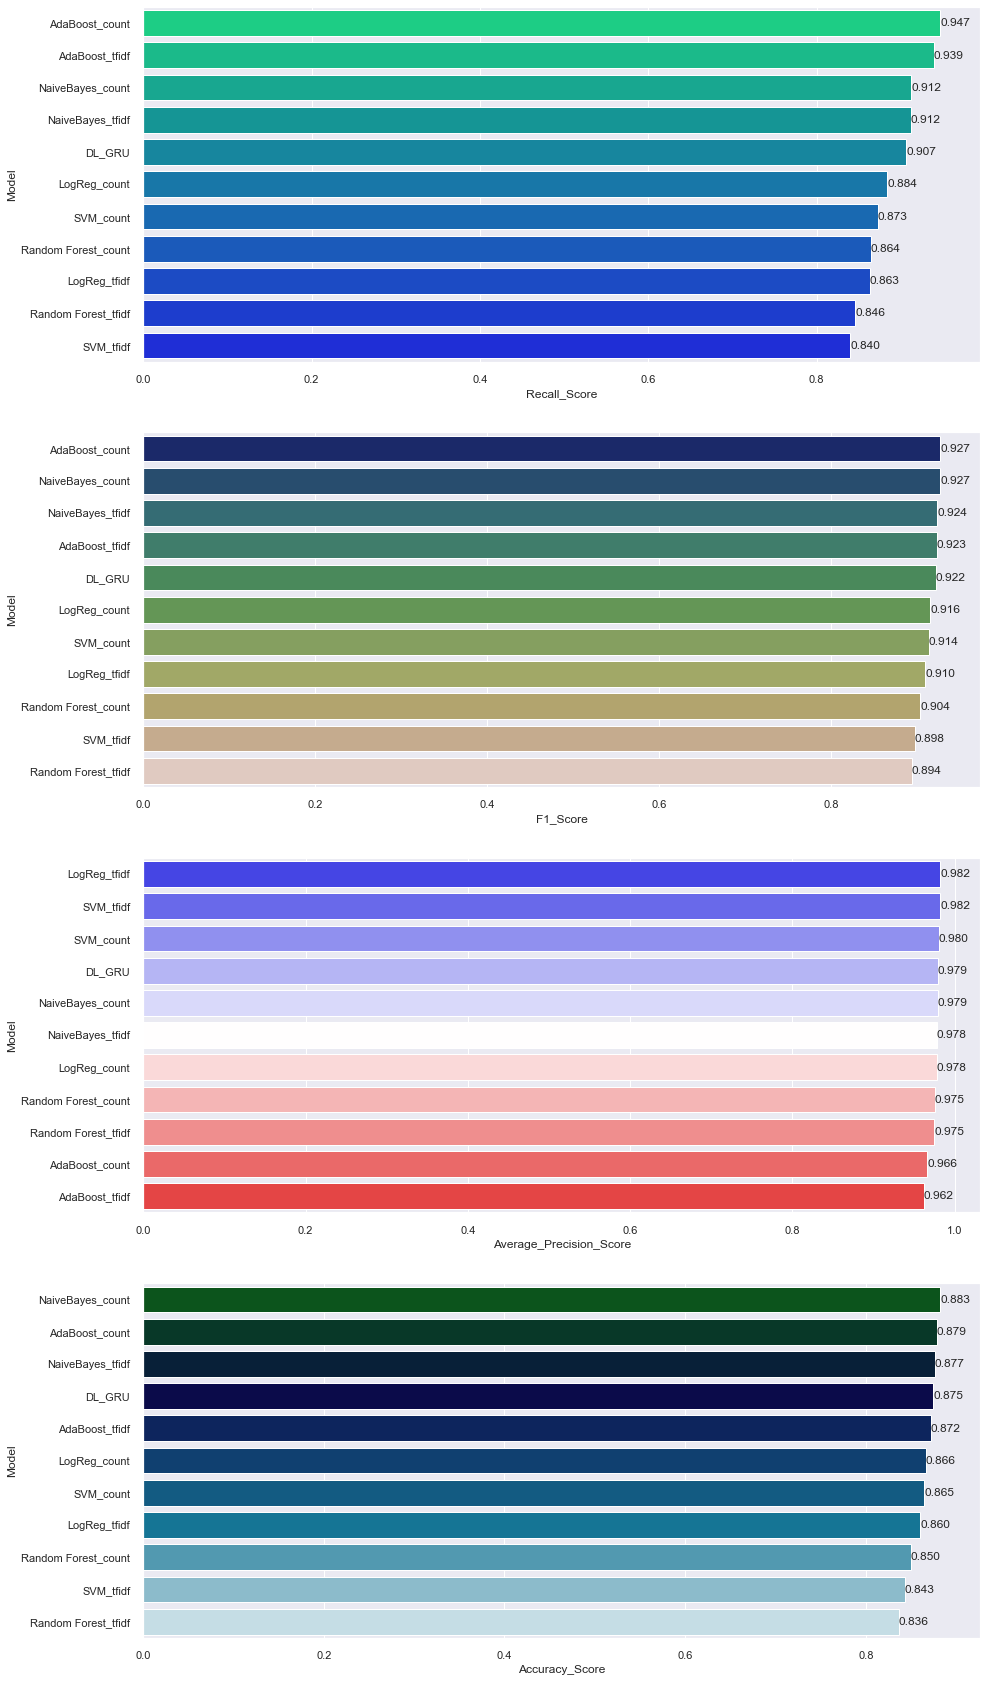

In [ ]:
compare = pd.DataFrame({"Model": ["NaiveBayes_count", "LogReg_count", "SVM_count", "Random Forest_count", 
                                  "AdaBoost_count", "NaiveBayes_tfidf", "LogReg_tfidf", "SVM_tfidf", 
                                  "Random Forest_tfidf", "AdaBoost_tfidf", "DL_GRU"],
                        
                        "F1_Score": [nb_count_f1, log_count_f1, svc_count_f1,
                                             rf_count_f1, ada_count_f1, nb_tfidf_f1, log_tfidf_f1,
                                             svc_tfidf_f1, rf_tfidf_f1, ada_tfidf_f1, DL_f1],
                        
                        "Recall_Score": [nb_count_rec, log_count_rec, svc_count_rec, 
                                                   rf_count_rec, ada_count_rec, 
                                                  nb_tfidf_rec, log_tfidf_rec, svc_tfidf_rec, 
                                                  rf_tfidf_rec, ada_tfidf_rec, DL_rec],
                        "Accuracy_Score": [nb_count_acc, log_count_acc, svc_count_acc, 
                                                   rf_count_acc, ada_count_acc, 
                                                  nb_tfidf_acc, log_tfidf_acc, svc_tfidf_acc, 
                                                  rf_tfidf_acc, ada_tfidf_acc, DL_acc],
                        
                        "Average_Precision_Score": [nb_AP_count, log_AP_count, svc_AP_count, rf_AP_count,
                                                   ada_AP_count, nb_AP_tfidf, log_AP_tfidf, svc_AP_tfidf,
                                                   rf_AP_tfidf, ada_AP_tfidf, DL_AP]})

def labels(ax):
                        
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(15,30))
plt.subplot(411)
compare = compare.sort_values(by="Recall_Score", ascending=False)
ax=sns.barplot(x="Recall_Score", y="Model", data=compare, palette="winter_r")
labels(ax)

plt.subplot(412)
compare = compare.sort_values(by="F1_Score", ascending=False)
ax=sns.barplot(x="F1_Score", y="Model", data=compare, palette="gist_earth")
labels(ax)


plt.subplot(413)
compare = compare.sort_values(by="Average_Precision_Score", ascending=False)
ax=sns.barplot(x="Average_Precision_Score", y="Model", data=compare, palette="bwr")
labels(ax)

plt.subplot(414)
compare = compare.sort_values(by="Accuracy_Score", ascending=False)
ax=sns.barplot(x="Accuracy_Score", y="Model", data=compare, palette="ocean")
labels(ax)

plt.show();

## 13) CONCLUSION

##### In this project we have used sentiment analysis to determine whether the product is recommended or not. We have used different machine learning algorithms to get more accurate predictions and deep learning algorithm for comparing it with machine learning models. The following classification algorithms have been used: Logistic Regression, Naive Bayes, Support Vector Machine (SVM), Random Forest and Ada Boosting. The dataset comes from Woman Clothing Review that can be find at Kaggle Website.

##### In general, when we compare the models it's hard to decide which model can be picked up among the ones that have been sharing top 5 since their scores are very close to each other. However, Ada Boosting, Naive Bayes, Deep Learning, SVM and LR's scores interchangeably look like better than other models' scores. There is no simple answer to the question of which one is better; each work better in different data sets and conditions. Each modelling algorithm has some pros and cons to each other. So we could select one of these algorithms in consistent with what we need, accuracy or precision.